In [59]:
import os
import statistics
import time
#from imblearn.over_sampling import *
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, AdaBoostClassifier, RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from sklearn.manifold import TSNE
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score, recall_score
from sklearn.preprocessing import RobustScaler, MinMaxScaler, QuantileTransformer, StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
# import umap
from sklearn import tree
#import graphviz

import tensorflow as tf
from tensorflow.keras import layers, models
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, Conv1DTranspose, Flatten, Dropout, Input, concatenate, LSTM,UpSampling1D, Reshape, TimeDistributed
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from keras.models import Model

import pickle
import warnings

In [60]:
pd.set_option('display.max_columns', None)

In [61]:
def window_nd(a, window, steps = None, axis = None, gen_data = False):
        """
        Create a windowed view over `n`-dimensional input that uses an 
        `m`-dimensional window, with `m <= n`
        
        Parameters
        -------------
        a : Array-like
            The array to create the view on
            
        window : tuple or int
            If int, the size of the window in `axis`, or in all dimensions if 
            `axis == None`
            
            If tuple, the shape of the desired window.  `window.size` must be:
                equal to `len(axis)` if `axis != None`, else 
                equal to `len(a.shape)`, or 
                1
                
        steps : tuple, int or None
            The offset between consecutive windows in desired dimension
            If None, offset is one in all dimensions
            If int, the offset for all windows over `axis`
            If tuple, the steps along each `axis`.  
                `len(steps)` must me equal to `len(axis)`
    
        axis : tuple, int or None
            The axes over which to apply the window
            If None, apply over all dimensions
            if tuple or int, the dimensions over which to apply the window

        gen_data : boolean
            returns data needed for a generator
    
        Returns
        -------
        
        a_view : ndarray
            A windowed view on the input array `a`, or `a, wshp`, where `whsp` is the window shape needed for creating the generator
            
        """
        ashp = np.array(a.shape)
        
        if axis != None:
            axs = np.array(axis, ndmin = 1)
            assert np.all(np.in1d(axs, np.arange(ashp.size))), "Axes out of range"
        else:
            axs = np.arange(ashp.size)
            
        window = np.array(window, ndmin = 1)
        assert (window.size == axs.size) | (window.size == 1), "Window dims and axes don't match"
        wshp = ashp.copy()
        wshp[axs] = window
        assert np.all(wshp <= ashp), "Window is bigger than input array in axes"
        
        stp = np.ones_like(ashp)
        if steps:
            steps = np.array(steps, ndmin = 1)
            assert np.all(steps > 0), "Only positive steps allowed"
            assert (steps.size == axs.size) | (steps.size == 1), "Steps and axes don't match"
            stp[axs] = steps
    
        astr = np.array(a.strides)
        
        shape = tuple((ashp - wshp) // stp + 1) + tuple(wshp)
        strides = tuple(astr * stp) + tuple(astr)
        
        as_strided = np.lib.stride_tricks.as_strided
        a_view = np.squeeze(as_strided(a, 
                                     shape = shape, 
                                     strides = strides))
        if gen_data :
            return a_view, shape[:-wshp.size]
        else:
            return a_view

In [62]:
def get_threshold_mse_iqr(autoencoder,train_data):
    if("pyod" in str(type(autoencoder))):
        return get_threshold_ml_score_iqr(autoencoder,train_data)
    
    train_predicted = autoencoder.predict(train_data,verbose=0)

    mse = np.mean(np.mean(np.power(train_data - train_predicted, 2), axis=2),axis=1)
    
    iqr = np.quantile(mse,0.75) - np.quantile(mse, 0.25)
    up_bound = np.quantile(mse,0.75) + 1.5*iqr
    bottom_bound = np.quantile(mse,0.25) - 1.5*iqr
    
    thres = [up_bound,bottom_bound]
    return thres

def get_threshold_mse_percentage(autoencoder,train_data,outlier_percentage):
    train_predicted = autoencoder.predict(train_data,verbose=0)
    
    mse = np.mean(np.mean(np.power(train_data - train_predicted, 2), axis=2),axis=1)
    #mse = np.mean(np.power(train_data - train_predicted, 2),axis=1)
    
    thresh = np.quantile(mse, 1-outlier_percentage)
    return [thresh]


#Predict outliers in "df" using "autoencoder" model and "threshold_mse" as anomaly limit
def detect_outliers(autoencoder, df, threshold_mse):
    if(len(threshold_mse)==2):
        return detect_outliers_range(autoencoder, df, threshold_mse)
    pred=autoencoder.predict(df,verbose=0)

    mse = np.mean(np.mean(np.power(df - pred, 2), axis=2),axis=1)
    #mse = np.mean(np.power(df - pred, 2),axis=1)
    
    #mse_plot = mse[mse>np.percentile(mse,0.95)]
    #plt.hist(mse_plot, bins=100)
    #plt.show()
    outliers = [(np.array(mse) < threshold_mse)]
    return outliers



def detect_outliers_range(autoencoder, df, threshold_mse):
    pred=autoencoder.predict(df)

    mse = np.mean(np.mean(np.power(df - pred, 2), axis=2),axis=1)
    #mse = np.mean(np.power(df - pred, 2),axis=1)

    up_bound = threshold_mse[0]
    bottom_bound = threshold_mse[1]
    outliers = [(np.array(mse) < up_bound)&(np.array(mse) > bottom_bound)]
    #outliers = [(np.array(mse) < up_bound)]
    return outliers

In [63]:
dataset_dir = "./LwHBench/data/"
n_samples_device = 800  # 10000
window = 10
n_recursive_windows = 10
jump = 10
initial_window = window
test_size = 0.2
feat_list = list(range(5,18))
feat_list.append(117)
feat_list=[5,6,7,8,9,11,12,14,15,17,117]
n_feat_selec = 15
model_1 = "3_"
model_2 = "4_"
# Dataset to be read and processed
mac_model_file = "./LwHBench/MAC-Model.txt"

In [64]:
file_names=sorted(os.listdir(dataset_dir))
df_dict={}
for f in file_names:
    print(f)
    df_dict[f]=pd.read_csv(dataset_dir+f,index_col=False)

feat_gpu_80_1f_02_ef_e7_b2
feat_gpu_80_1f_02_f1_e3_b0
feat_gpu_80_1f_02_f1_e3_b7
feat_gpu_80_1f_02_f1_e3_c0
feat_gpu_80_1f_02_f1_e3_c7
feat_gpu_80_1f_02_f1_e3_db
feat_gpu_80_1f_02_f1_e3_dd
feat_gpu_80_1f_02_f1_e3_e0
feat_gpu_80_1f_02_f1_e4_04
feat_gpu_80_1f_02_f1_e4_0c
feat_gpu_b8_27_eb_0e_9d_fb
feat_gpu_b8_27_eb_1d_3b_13
feat_gpu_b8_27_eb_27_1f_a3
feat_gpu_b8_27_eb_2d_18_19
feat_gpu_b8_27_eb_2d_d7_6b
feat_gpu_b8_27_eb_31_6d_f3
feat_gpu_b8_27_eb_4c_33_1b
feat_gpu_b8_27_eb_4c_53_a8
feat_gpu_b8_27_eb_50_d7_8b
feat_gpu_b8_27_eb_6d_af_a9
feat_gpu_b8_27_eb_7f_ec_53
feat_gpu_b8_27_eb_87_a7_ce
feat_gpu_b8_27_eb_8c_24_61
feat_gpu_b8_27_eb_8e_97_06
feat_gpu_b8_27_eb_91_48_fe
feat_gpu_b8_27_eb_c2_b6_e9
feat_gpu_b8_27_eb_d5_e5_0b
feat_gpu_b8_27_eb_dc_61_2f
feat_gpu_b8_27_eb_e1_66_63
feat_gpu_b8_27_eb_ea_38_52
feat_gpu_dc_a6_32_14_a6_53
feat_gpu_dc_a6_32_14_a8_d8
feat_gpu_dc_a6_32_14_ab_0a
feat_gpu_dc_a6_32_4c_8e_0a
feat_gpu_dc_a6_32_4c_90_fb
feat_gpu_dc_a6_32_4c_98_93
feat_gpu_dc_a6_32_4c_99_bf
f

In [65]:
warnings.filterwarnings("ignore")

In [66]:
mac_model = {}
with open(mac_model_file) as f:
    for line in f:
        p = line.split(" ")
        mac_model[p[0]] = p[3]
for f in file_names:
    df_dict[f]["label"] = df_dict[f]["label"].apply(lambda x: mac_model[str(x)]+ "_" + str(x))

In [67]:
df_labels={}
for f in file_names:
    df_labels[f] = df_dict[f]["label"]
    df_dict[f] = df_dict[f].iloc[:,2:-1]#[:, 1:]

In [68]:
df_dict_train={}
df_dict_test={}

In [69]:
for f in file_names:
    train_idx, test_idx = next(StratifiedKFold(n_splits=5).split(df_dict[f],df_labels[f]))
    df_dict_train[f], df_dict_test[f] = df_dict[f].iloc[train_idx], df_dict[f].iloc[test_idx]

In [70]:
df_dict_train["feat_gpu_dc_a6_32_14_a6_53"]

,cpu_sleep_1s,cpu_sleep_2s,cpu_sleep_5s,cpu_sleep_10s,cpu_sleep_120s,cpu_hash,cpu_pseudorandom,cpu_urandom,cpu_fib,gpu_matrixmul,gpu_sum,gpu_scopy,mem_list,mem_reserve,mem_csvread,storage_read_1,storage_read_2,storage_read_3,storage_read_4,storage_read_5,storage_read_6,storage_read_7,storage_read_8,storage_read_9,storage_read_10,storage_read_11,storage_read_12,storage_read_13,storage_read_14,storage_read_15,storage_read_16,storage_read_17,storage_read_18,storage_read_19,storage_read_20,storage_read_21,storage_read_22,storage_read_23,storage_read_24,storage_read_25,storage_read_26,storage_read_27,storage_read_28,storage_read_29,storage_read_30,storage_read_31,storage_read_32,storage_read_33,storage_read_34,storage_read_35,storage_read_36,storage_read_37,storage_read_38,storage_read_39,storage_read_40,storage_read_41,storage_read_42,storage_read_43,storage_read_44,storage_read_45,storage_read_46,storage_read_47,storage_read_48,storage_read_49,storage_read_50,storage_read_51,storage_read_52,storage_read_53,storage_read_54,storage_read_55,storage_read_56,storage_read_57,storage_read_58,storage_read_59,storage_read_60,storage_read_61,storage_read_62,storage_read_63,storage_read_64,storage_read_65,storage_read_66,storage_read_67,storage_read_68,storage_read_69,storage_read_70,storage_read_71,storage_read_72,storage_read_73,storage_read_74,storage_read_75,storage_read_76,storage_read_77,storage_read_78,storage_read_79,storage_read_80,storage_read_81,storage_read_82,storage_read_83,storage_read_84,storage_read_85,storage_read_86,storage_read_87,storage_read_88,storage_read_89,storage_read_90,storage_read_91,storage_read_92,storage_read_93,storage_read_94,storage_read_95,storage_read_96,storage_read_97,storage_read_98,storage_read_99,storage_read_100,storage_write_1,storage_write_2,storage_write_3,storage_write_4,storage_write_5,storage_write_6,storage_write_7,storage_write_8,storage_write_9,storage_write_10,storage_write_11,storage_write_12,storage_write_13,storage_write_14,storage_write_15,storage_write_16,storage_write_17,storage_write_18,storage_write_19,storage_write_20,storage_write_21,storage_write_22,storage_write_23,storage_write_24,storage_write_25,storage_write_26,storage_write_27,storage_write_28,storage_write_29,storage_write_30,storage_write_31,storage_write_32,storage_write_33,storage_write_34,storage_write_35,storage_write_36,storage_write_37,storage_write_38,storage_write_39,storage_write_40,storage_write_41,storage_write_42,storage_write_43,storage_write_44,storage_write_45,storage_write_46,storage_write_47,storage_write_48,storage_write_49,storage_write_50,storage_write_51,storage_write_52,storage_write_53,storage_write_54,storage_write_55,storage_write_56,storage_write_57,storage_write_58,storage_write_59,storage_write_60,storage_write_61,storage_write_62,storage_write_63,storage_write_64,storage_write_65,storage_write_66,storage_write_67,storage_write_68,storage_write_69,storage_write_70,storage_write_71,storage_write_72,storage_write_73,storage_write_74,storage_write_75,storage_write_76,storage_write_77,storage_write_78,storage_write_79,storage_write_80,storage_write_81,storage_write_82,storage_write_83,storage_write_84,storage_write_85,storage_write_86,storage_write_87,storage_write_88,storage_write_89,storage_write_90,storage_write_91,storage_write_92,storage_write_93,storage_write_94,storage_write_95,storage_write_96,storage_write_97,storage_write_98,storage_write_99,storage_write_100
10349,500.040883,1000.037750,2500.063642,705.127493,4166.311095,43243,18734,2757221312,3642399,552160088,19131818,29319986,807211,286972957,36634049,10956195,8879891,10534201,10324112,10279520,12725391,8485656,8849984,10541404,10826660,8563748,11004380,8680561,8872650,8740967,10861548,8302880,10621681,8135847,8250622,9552474,8295178,8207197,10453517,8250382,8506175,8602413,8409657,10415962,12601356,8167587,6137634,5492829,5998544,5891860,7814591,5529272,6217429,5991803,6185449,6902642,5980136,7421468,5681677,5966192,6109616,756789

In [71]:
df_dict_test["feat_gpu_dc_a6_32_14_a6_53"]

,cpu_sleep_1s,cpu_sleep_2s,cpu_sleep_5s,cpu_sleep_10s,cpu_sleep_120s,cpu_hash,cpu_pseudorandom,cpu_urandom,cpu_fib,gpu_matrixmul,gpu_sum,gpu_scopy,mem_list,mem_reserve,mem_csvread,storage_read_1,storage_read_2,storage_read_3,storage_read_4,storage_read_5,storage_read_6,storage_read_7,storage_read_8,storage_read_9,storage_read_10,storage_read_11,storage_read_12,storage_read_13,storage_read_14,storage_read_15,storage_read_16,storage_read_17,storage_read_18,storage_read_19,storage_read_20,storage_read_21,storage_read_22,storage_read_23,storage_read_24,storage_read_25,storage_read_26,storage_read_27,storage_read_28,storage_read_29,storage_read_30,storage_read_31,storage_read_32,storage_read_33,storage_read_34,storage_read_35,storage_read_36,storage_read_37,storage_read_38,storage_read_39,storage_read_40,storage_read_41,storage_read_42,storage_read_43,storage_read_44,storage_read_45,storage_read_46,storage_read_47,storage_read_48,storage_read_49,storage_read_50,storage_read_51,storage_read_52,storage_read_53,storage_read_54,storage_read_55,storage_read_56,storage_read_57,storage_read_58,storage_read_59,storage_read_60,storage_read_61,storage_read_62,storage_read_63,storage_read_64,storage_read_65,storage_read_66,storage_read_67,storage_read_68,storage_read_69,storage_read_70,storage_read_71,storage_read_72,storage_read_73,storage_read_74,storage_read_75,storage_read_76,storage_read_77,storage_read_78,storage_read_79,storage_read_80,storage_read_81,storage_read_82,storage_read_83,storage_read_84,storage_read_85,storage_read_86,storage_read_87,storage_read_88,storage_read_89,storage_read_90,storage_read_91,storage_read_92,storage_read_93,storage_read_94,storage_read_95,storage_read_96,storage_read_97,storage_read_98,storage_read_99,storage_read_100,storage_write_1,storage_write_2,storage_write_3,storage_write_4,storage_write_5,storage_write_6,storage_write_7,storage_write_8,storage_write_9,storage_write_10,storage_write_11,storage_write_12,storage_write_13,storage_write_14,storage_write_15,storage_write_16,storage_write_17,storage_write_18,storage_write_19,storage_write_20,storage_write_21,storage_write_22,storage_write_23,storage_write_24,storage_write_25,storage_write_26,storage_write_27,storage_write_28,storage_write_29,storage_write_30,storage_write_31,storage_write_32,storage_write_33,storage_write_34,storage_write_35,storage_write_36,storage_write_37,storage_write_38,storage_write_39,storage_write_40,storage_write_41,storage_write_42,storage_write_43,storage_write_44,storage_write_45,storage_write_46,storage_write_47,storage_write_48,storage_write_49,storage_write_50,storage_write_51,storage_write_52,storage_write_53,storage_write_54,storage_write_55,storage_write_56,storage_write_57,storage_write_58,storage_write_59,storage_write_60,storage_write_61,storage_write_62,storage_write_63,storage_write_64,storage_write_65,storage_write_66,storage_write_67,storage_write_68,storage_write_69,storage_write_70,storage_write_71,storage_write_72,storage_write_73,storage_write_74,storage_write_75,storage_write_76,storage_write_77,storage_write_78,storage_write_79,storage_write_80,storage_write_81,storage_write_82,storage_write_83,storage_write_84,storage_write_85,storage_write_86,storage_write_87,storage_write_88,storage_write_89,storage_write_90,storage_write_91,storage_write_92,storage_write_93,storage_write_94,storage_write_95,storage_write_96,storage_write_97,storage_write_98,storage_write_99,storage_write_100
0,500.064438,1000.043082,2500.043863,705.072362,4165.923007,47995,20373,2769748383,3536579,555686812,19477002,29388281,817643,287888516,58828470,8364038,7017214,9463958,5874610,5834036,6163534,8185817,65191595,10743708,8249743,8386057,13285525,8600055,10591487,8593019,10311100,8394093,10335859,12833343,12588715,14498683,8362205,8442037,8478500,16589263,10656245,8278965,10488080,17270055,11071465,8353131,10658801,16546467,8448149,8168855,8517519,8270187,20178332,8362612,8514000,12956972,15024698,8559722,10525339,8445131,15034717,84

In [72]:
df_dict_test_df={}

In [73]:
for f in file_names:
    #df_dict_train[f]=df_dict_train[f][(np.abs(stats.zscore(df_dict_train[f])) < 15).all(axis=1)]
    scc = QuantileTransformer(n_quantiles=1000)#QuantileTransformer() #StandardScaler()
    scc.fit(df_dict_train[f])
    df_dict_train[f] = scc.transform(df_dict_train[f])
    
    df_dict_test_df[f]={}
    for f2 in file_names: 
        df_dict_test_df[f][f2] = scc.transform(df_dict_test[f2])

In [74]:
n_timesteps=10 #100 

In [75]:
window_nd(df_dict_train["feat_gpu_dc_a6_32_14_a6_53"],n_timesteps,axis=0).shape

(41386, 10, 215)

In [76]:
for f in file_names:
    #df_dict_train[f] = df_dict_train[f][:(df_dict_train[f].shape[0]//n_timesteps)*n_timesteps]
    #df_dict_train[f]=df_dict_train[f].reshape((int(df_dict_train[f].shape[0]/n_timesteps),n_timesteps, df_dict_train[f].shape[1]))
    df_dict_train[f]=window_nd(df_dict_train[f],n_timesteps,axis=0)
    
    for f2 in file_names:
        #df_dict_test_df[f][f2] = df_dict_test_df[f][f2][:(df_dict_test_df[f][f2].shape[0]//n_timesteps)*n_timesteps]    
        #df_dict_test_df[f][f2] = df_dict_test_df[f][f2].reshape((int(df_dict_test_df[f][f2].shape[0]/n_timesteps),n_timesteps, df_dict_test_df[f][f2].shape[1]))
        df_dict_test_df[f][f2]=window_nd(df_dict_test_df[f][f2],n_timesteps,axis=0)

In [77]:
unidentified_devices=['feat_gpu_80_1f_02_f1_e3_b0','feat_gpu_80_1f_02_f1_e3_c0', 'feat_gpu_80_1f_02_f1_e3_dd', 'feat_gpu_b8_27_eb_27_1f_a3', 'feat_gpu_b8_27_eb_2d_d7_6b', 'feat_gpu_b8_27_eb_4c_53_a8', 'feat_gpu_b8_27_eb_91_48_fe', 'feat_gpu_dc_a6_32_14_a8_d8', 'feat_gpu_dc_a6_32_14_ab_0a', 'feat_gpu_dc_a6_32_e4_48_9e']
unidentified_devices=['feat_gpu_dc_a6_32_14_ab_0a']

In [78]:
df_dict_train["feat_gpu_dc_a6_32_14_a6_53"].shape
#8279*5

(41386, 10, 215)

In [84]:
def generate_model():

    model = Sequential()
    #model.add(Dense(100, activation='relu', input_shape=(215,)))
    
    model.add(LSTM(64,return_sequences=False, activation='relu', input_shape=(n_timesteps,215)))
    #model.add(LSTM(64,return_sequences=False, activation='relu'))

    #model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))#True = many to many
    #model.add(Dropout(0.2))
    #model.add(MaxPooling1D(pool_size=2))
    #model.add(Flatten())
    mid_layer=50
    model.add(Dense(mid_layer, activation='relu'))
    model.add(Reshape((n_timesteps,mid_layer//n_timesteps)))
    
    #model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    #model.add(UpSampling1D(2))
    #model.add(LSTM(64,return_sequences=True, activation='relu'))
    
    #model.add(Conv1DTranspose(filters=64, kernel_size=3, activation='relu'))
    #model.add(UpSampling1D(2))
    
    model.add(LSTM(64,return_sequences=True, activation='relu'))
    model.add(TimeDistributed(Dense(215)))
    
    #model.add(Dense(215, activation='relu'))
    
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [86]:
max_FPR={}
TPR={}
strategy = tf.distribute.MirroredStrategy()

print(f'Number of devices: {strategy.num_replicas_in_sync}')

with strategy.scope():

    for f in file_names:    

        #Training
        print("Training model for "+f)
        model=generate_model()
        es = EarlyStopping(monitor='loss', mode='min',patience=20)
        mc = ModelCheckpoint('best_model_autoenc_'+f+'.h5', monitor='loss', mode='min', save_best_only=True)

        history = model.fit(df_dict_train[f], df_dict_train[f], epochs=10, batch_size=32, verbose=1, callbacks=[es, mc])#, validation_data=(X_val, y_val), callbacks=[es, mc])

        #Denoising
        #noise_factor = 0.05
        #X_train_noisy = df_dict_train[f] + noise_factor * np.random.normal(size=df_dict_train[f].shape)
        #X_train_noisy = np.clip(X_train_noisy, 0., 1.)
        #history = model.fit(X_train_noisy, df_dict_train[f], epochs=10, batch_size=32, verbose=1, callbacks=[es, mc])#, validation_data=(X_val, y_val), callbacks=[es, mc])

        model = load_model('best_model_autoenc_'+f+'.h5')

        #Eval
        max_FPR[f]=0

        thresh = get_threshold_mse_percentage(model,df_dict_train[f],0.10)
        print(thresh)

        mad_outliers = detect_outliers(model, df_dict_train[f], thresh)
        unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
        print(unique_elements,"    ",counts_elements/mad_outliers[0].shape[0])        

        mad_outliers = detect_outliers(model, df_dict_test_df[f][f], thresh)
        unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
        print(unique_elements,"    ",counts_elements/mad_outliers[0].shape[0],"    ",counts_elements)

        if len(counts_elements)==2:
            TPR[f]=counts_elements[1]/mad_outliers[0].shape[0]
        else:
            TPR[f]=0

        for f2 in file_names:
            if f != f2 and f.startswith(f2[:10]):
                mad_outliers = detect_outliers(model, df_dict_test_df[f][f2], thresh)
                unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
                print(f2+" "+str(counts_elements))
                if len(counts_elements)==2 and (counts_elements[1]/mad_outliers[0].shape[0])>max_FPR[f]:
                    max_FPR[f]=counts_elements[1]/mad_outliers[0].shape[0]

        print(max_FPR[f])

        print("\n")


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
Training model for feat_gpu_80_1f_02_ef_e7_b2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                71680     
    

[False  True]      [0.10001594 0.89998406]
[False  True]      [0.15916135 0.84083865]      [1746 9224]
feat_gpu_80_1f_02_ef_e7_b2 [3373 7591]
feat_gpu_80_1f_02_f1_e3_b7 [3758 7209]
feat_gpu_80_1f_02_f1_e3_c0 [5765 5200]
feat_gpu_80_1f_02_f1_e3_c7 [4723 6229]
feat_gpu_80_1f_02_f1_e3_db [6823 4145]
feat_gpu_80_1f_02_f1_e3_dd [6155 4807]
feat_gpu_80_1f_02_f1_e3_e0 [6439 4525]
feat_gpu_80_1f_02_f1_e4_04 [5360 5607]
feat_gpu_80_1f_02_f1_e4_0c [5652 5313]
0.6923568040861


Training model for feat_gpu_80_1f_02_f1_e3_b7
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 64)                71680     
                                                                 
 dense_7 (Dense)             (None, 50)                3250      
                                                                 
 reshape_4 (Reshape)         (None, 10, 5)             0        

                                                                 
 dense_11 (Dense)            (None, 50)                3250      
                                                                 
 reshape_6 (Reshape)         (None, 10, 5)             0         
                                                                 
 lstm_13 (LSTM)              (None, 10, 64)            17920     
                                                                 
 time_distributed_5 (TimeDis  (None, 10, 215)          13975     
 tributed)                                                       
                                                                 
Total params: 106,825
Trainable params: 106,825
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1
1370/1370 [========

1372/1372 [==============================] - 31s 23ms/step - loss: 0.0459 - accuracy: 0.0148
Epoch 5/10
1372/1372 [==============================] - 31s 23ms/step - loss: 0.0453 - accuracy: 0.0152
Epoch 6/10
1372/1372 [==============================] - 31s 23ms/step - loss: 0.0446 - accuracy: 0.0144
Epoch 7/10
1372/1372 [==============================] - 31s 23ms/step - loss: 0.0438 - accuracy: 0.0124
Epoch 8/10
1372/1372 [==============================] - 31s 23ms/step - loss: 0.0428 - accuracy: 0.0095
Epoch 9/10
1372/1372 [==============================] - 31s 23ms/step - loss: 0.0424 - accuracy: 0.0095
Epoch 10/10
1372/1372 [==============================] - 31s 23ms/step - loss: 0.0421 - accuracy: 0.0096
[0.04632526563306936]
[False  True]      [0.10001596 0.89998404]
[False  True]      [0.10399562 0.89600438]      [1140 9822]
feat_gpu_80_1f_02_ef_e7_b2 [2272 8692]
feat_gpu_80_1f_02_f1_e3_b0 [6387 4583]
feat_gpu_80_1f_02_f1_e3_b7 [5979 4988]
feat_gpu_80_1f_02_f1_e3_c0 [9364 1601]
f

feat_gpu_80_1f_02_f1_e3_e0 [7756 3208]
feat_gpu_80_1f_02_f1_e4_0c [6238 4727]
0.6426486683692083


Training model for feat_gpu_80_1f_02_f1_e4_0c
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 64)                71680     
                                                                 
 dense_21 (Dense)            (None, 50)                3250      
                                                                 
 reshape_11 (Reshape)        (None, 10, 5)             0         
                                                                 
 lstm_23 (LSTM)              (None, 10, 64)            17920     
                                                                 
 time_distributed_10 (TimeDi  (None, 10, 215)          13975     
 stributed)                                                      
                                        

 lstm_27 (LSTM)              (None, 10, 64)            17920     
                                                                 
 time_distributed_12 (TimeDi  (None, 10, 215)          13975     
 stributed)                                                      
                                                                 
Total params: 106,825
Trainable params: 106,825
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1315/1315 [==============================] - 38s 23ms/step - loss: 0.0795 - accuracy: 0.0035
Epoch 2/10
1315/1315 [==============================] - 31s 23ms/step - loss: 0.0738 - accuracy: 0.0040
Epoch 3/10
1315/1315 [==============================] - 31s 23ms/step - loss: 0.0714 - accuracy: 0.0050
Epoch 4/10
1315/1315 [==============================] - 30s 23ms/step - loss: 0.0682 - accuracy: 0.0045
Epoch 5/10
1315/1315 [==============================] - 30s 23ms/step - loss: 0.0670 - accuracy: 0.0042
Epoch 6/10
1

1316/1316 [==============================] - 31s 23ms/step - loss: 0.0764 - accuracy: 0.0031
Epoch 3/10
1316/1316 [==============================] - 31s 23ms/step - loss: 0.0750 - accuracy: 0.0033
Epoch 4/10
1316/1316 [==============================] - 30s 23ms/step - loss: 0.0727 - accuracy: 0.0034
Epoch 5/10
1316/1316 [==============================] - 30s 23ms/step - loss: 0.0707 - accuracy: 0.0033
Epoch 6/10
1316/1316 [==============================] - 30s 23ms/step - loss: 0.0702 - accuracy: 0.0035
Epoch 7/10
1316/1316 [==============================] - 31s 23ms/step - loss: 0.0699 - accuracy: 0.0035
Epoch 8/10
1316/1316 [==============================] - 30s 23ms/step - loss: 0.0696 - accuracy: 0.0034
Epoch 9/10
1316/1316 [==============================] - 30s 23ms/step - loss: 0.0693 - accuracy: 0.0034
Epoch 10/10
1316/1316 [==============================] - 30s 23ms/step - loss: 0.0690 - accuracy: 0.0035
[0.07368925745049204]
[False  True]      [0.1000095 0.8999905]
[False  Tru

1315/1315 [==============================] - 30s 23ms/step - loss: 0.0671 - accuracy: 0.0039
Epoch 9/10
1315/1315 [==============================] - 30s 23ms/step - loss: 0.0667 - accuracy: 0.0040
Epoch 10/10
1315/1315 [==============================] - 30s 23ms/step - loss: 0.0663 - accuracy: 0.0040
[0.0724133164396129]
[False  True]      [0.10001189 0.89998811]
[False  True]      [0.14405328 0.85594672]      [1514 8996]
feat_gpu_b8_27_eb_0e_9d_fb [8509]
feat_gpu_b8_27_eb_1d_3b_13 [10508     1]
feat_gpu_b8_27_eb_27_1f_a3 [10511]
feat_gpu_b8_27_eb_2d_18_19 [10515]
feat_gpu_b8_27_eb_2d_d7_6b [10513]
feat_gpu_b8_27_eb_4c_33_1b [10511]
feat_gpu_b8_27_eb_4c_53_a8 [11903]
feat_gpu_b8_27_eb_50_d7_8b [11907]
feat_gpu_b8_27_eb_6d_af_a9 [10511]
feat_gpu_b8_27_eb_7f_ec_53 [11903]
feat_gpu_b8_27_eb_87_a7_ce [6430]
feat_gpu_b8_27_eb_8c_24_61 [11903]
feat_gpu_b8_27_eb_8e_97_06 [10509     1]
feat_gpu_b8_27_eb_91_48_fe [10510]
feat_gpu_b8_27_eb_c2_b6_e9 [11908]
feat_gpu_b8_27_eb_d5_e5_0b [5768]
feat_

feat_gpu_b8_27_eb_1d_3b_13 [10509]
feat_gpu_b8_27_eb_27_1f_a3 [10511]
feat_gpu_b8_27_eb_2d_18_19 [10515]
feat_gpu_b8_27_eb_2d_d7_6b [10513]
feat_gpu_b8_27_eb_31_6d_f3 [10510]
feat_gpu_b8_27_eb_4c_33_1b [10511]
feat_gpu_b8_27_eb_50_d7_8b [10790  1117]
feat_gpu_b8_27_eb_6d_af_a9 [10511]
feat_gpu_b8_27_eb_7f_ec_53 [10737  1166]
feat_gpu_b8_27_eb_87_a7_ce [6430]
feat_gpu_b8_27_eb_8c_24_61 [ 1434 10469]
feat_gpu_b8_27_eb_8e_97_06 [10510]
feat_gpu_b8_27_eb_91_48_fe [10510]
feat_gpu_b8_27_eb_c2_b6_e9 [10798  1110]
feat_gpu_b8_27_eb_d5_e5_0b [4656 1112]
feat_gpu_b8_27_eb_dc_61_2f [3334 8562]
feat_gpu_b8_27_eb_e1_66_63 [10732  1171]
feat_gpu_b8_27_eb_ea_38_52 [4609 7265]
0.8795261698731413


Training model for feat_gpu_b8_27_eb_50_d7_8b
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 64)                71680     
                                         

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 64)                71680     
                                                                 
 dense_43 (Dense)            (None, 50)                3250      
                                                                 
 reshape_22 (Reshape)        (None, 10, 5)             0         
                                                                 
 lstm_45 (LSTM)              (None, 10, 64)            17920     
                                                                 
 time_distributed_21 (TimeDi  (None, 10, 215)          13975     
 stributed)                                                      
                                                                 
Total params: 106,825
Trainable params: 106,825
Non-trainable params: 0
_______________________________________________

                                                                 
 lstm_49 (LSTM)              (None, 10, 64)            17920     
                                                                 
 time_distributed_23 (TimeDi  (None, 10, 215)          13975     
 stributed)                                                      
                                                                 
Total params: 106,825
Trainable params: 106,825
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1489/1489 [==============================] - 40s 23ms/step - loss: 0.0838 - accuracy: 0.0053
Epoch 2/10
1489/1489 [==============================] - 34s 23ms/step - loss: 0.0706 - accuracy: 0.0037
Epoch 3/10
1489/1489 [==============================] - 34s 23ms/step - loss: 0.0676 - accuracy: 0.0036
Epoch 4/10
1489/1489 [==============================] - 34s 23ms/step - loss: 0.0646 - accuracy: 0.0034
Epoch 5/10
1489/1489 [============================

1315/1315 [==============================] - 30s 23ms/step - loss: 0.0720 - accuracy: 0.0034
Epoch 3/10
1315/1315 [==============================] - 31s 23ms/step - loss: 0.0706 - accuracy: 0.0035
Epoch 4/10
1315/1315 [==============================] - 31s 23ms/step - loss: 0.0698 - accuracy: 0.0033
Epoch 5/10
1315/1315 [==============================] - 31s 23ms/step - loss: 0.0690 - accuracy: 0.0032
Epoch 6/10
1315/1315 [==============================] - 31s 23ms/step - loss: 0.0684 - accuracy: 0.0032
Epoch 7/10
1315/1315 [==============================] - 31s 23ms/step - loss: 0.0679 - accuracy: 0.0033
Epoch 8/10
1315/1315 [==============================] - 31s 23ms/step - loss: 0.0675 - accuracy: 0.0035
Epoch 9/10
1315/1315 [==============================] - 31s 23ms/step - loss: 0.0672 - accuracy: 0.0035
Epoch 10/10
1315/1315 [==============================] - 31s 23ms/step - loss: 0.0668 - accuracy: 0.0039
[0.07260588115944848]
[False  True]      [0.10001189 0.89998811]
[False  T

722/722 [==============================] - 17s 23ms/step - loss: 0.0619 - accuracy: 0.0028
Epoch 10/10
722/722 [==============================] - 17s 23ms/step - loss: 0.0617 - accuracy: 0.0028
[0.06786904225553425]
[False  True]      [0.10000433 0.89999567]
[False  True]      [0.06397365 0.93602635]      [ 369 5399]
feat_gpu_b8_27_eb_0e_9d_fb [7397 1112]
feat_gpu_b8_27_eb_1d_3b_13 [10509]
feat_gpu_b8_27_eb_27_1f_a3 [10511]
feat_gpu_b8_27_eb_2d_18_19 [10515]
feat_gpu_b8_27_eb_2d_d7_6b [10513]
feat_gpu_b8_27_eb_31_6d_f3 [10510]
feat_gpu_b8_27_eb_4c_33_1b [10511]
feat_gpu_b8_27_eb_4c_53_a8 [10796  1107]
feat_gpu_b8_27_eb_50_d7_8b [10767  1140]
feat_gpu_b8_27_eb_6d_af_a9 [10511]
feat_gpu_b8_27_eb_7f_ec_53 [3853 8050]
feat_gpu_b8_27_eb_87_a7_ce [6430]
feat_gpu_b8_27_eb_8c_24_61 [10788  1115]
feat_gpu_b8_27_eb_8e_97_06 [10510]
feat_gpu_b8_27_eb_91_48_fe [10510]
feat_gpu_b8_27_eb_c2_b6_e9 [10797  1111]
feat_gpu_b8_27_eb_dc_61_2f [10775  1121]
feat_gpu_b8_27_eb_e1_66_63 [10666  1237]
feat_gpu

feat_gpu_b8_27_eb_2d_18_19 [10515]
feat_gpu_b8_27_eb_2d_d7_6b [10513]
feat_gpu_b8_27_eb_31_6d_f3 [10510]
feat_gpu_b8_27_eb_4c_33_1b [10511]
feat_gpu_b8_27_eb_4c_53_a8 [10801  1102]
feat_gpu_b8_27_eb_50_d7_8b [10796  1111]
feat_gpu_b8_27_eb_6d_af_a9 [10511]
feat_gpu_b8_27_eb_7f_ec_53 [10777  1126]
feat_gpu_b8_27_eb_87_a7_ce [6430]
feat_gpu_b8_27_eb_8c_24_61 [10791  1112]
feat_gpu_b8_27_eb_8e_97_06 [10510]
feat_gpu_b8_27_eb_91_48_fe [10510]
feat_gpu_b8_27_eb_c2_b6_e9 [10798  1110]
feat_gpu_b8_27_eb_d5_e5_0b [4667 1101]
feat_gpu_b8_27_eb_dc_61_2f [10778  1118]
feat_gpu_b8_27_eb_ea_38_52 [4623 7251]
0.6106619504800405


Training model for feat_gpu_b8_27_eb_ea_38_52
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 64)                71680     
                                                                 
 dense_61 (Dense)            (None, 50)    

 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, 64)                71680     
                                                                 
 dense_65 (Dense)            (None, 50)                3250      
                                                                 
 reshape_33 (Reshape)        (None, 10, 5)             0         
                                                                 
 lstm_67 (LSTM)              (None, 10, 64)            17920     
                                                                 
 time_distributed_32 (TimeDi  (None, 10, 215)          13975     
 stributed)                                                      
                                                                 
Total params: 106,825
Trainable params: 106,825
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1293/1293 [==============================] - 36s 23ms/step 

1402/1402 [==============================] - 33s 23ms/step - loss: 0.0611 - accuracy: 0.0053
Epoch 5/10
1402/1402 [==============================] - 33s 23ms/step - loss: 0.0600 - accuracy: 0.0052
Epoch 6/10
1402/1402 [==============================] - 32s 23ms/step - loss: 0.0591 - accuracy: 0.0052
Epoch 7/10
1402/1402 [==============================] - 32s 23ms/step - loss: 0.0586 - accuracy: 0.0052
Epoch 8/10
1402/1402 [==============================] - 32s 23ms/step - loss: 0.0583 - accuracy: 0.0050
Epoch 9/10
1402/1402 [==============================] - 32s 23ms/step - loss: 0.0580 - accuracy: 0.0048
Epoch 10/10
1402/1402 [==============================] - 32s 23ms/step - loss: 0.0579 - accuracy: 0.0049
[0.06374490967770716]
[False  True]      [0.1000156 0.8999844]
[False  True]      [0.06887323 0.93112677]      [  772 10437]
feat_gpu_dc_a6_32_14_a6_53 [10340]
feat_gpu_dc_a6_32_14_a8_d8 [10338]
feat_gpu_dc_a6_32_14_ab_0a [10340]
feat_gpu_dc_a6_32_4c_90_fb [9851  279]
feat_gpu_dc_a

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_76 (LSTM)              (None, 64)                71680     
                                                                 
 dense_75 (Dense)            (None, 50)                3250      
                                                                 
 reshape_38 (Reshape)        (None, 10, 5)             0         
                                                                 
 lstm_77 (LSTM)              (None, 10, 64)            17920     
                                                                 
 time_distributed_37 (TimeDi  (None, 10, 215)          13975     
 stributed)                                                      
                                                                 
Total params: 106,825
Trainable params: 106,825
Non-trainable params: 0
_______________________________________________

1297/1297 [==============================] - 30s 23ms/step - loss: 0.0624 - accuracy: 0.0054
Epoch 3/10
1297/1297 [==============================] - 31s 24ms/step - loss: 0.0605 - accuracy: 0.0056
Epoch 4/10
1297/1297 [==============================] - 30s 23ms/step - loss: 0.0593 - accuracy: 0.0062
Epoch 5/10
1297/1297 [==============================] - 30s 23ms/step - loss: 0.0577 - accuracy: 0.0063
Epoch 6/10
1297/1297 [==============================] - 30s 23ms/step - loss: 0.0565 - accuracy: 0.0055
Epoch 7/10
1297/1297 [==============================] - 30s 23ms/step - loss: 0.0556 - accuracy: 0.0051
Epoch 8/10
1297/1297 [==============================] - 30s 23ms/step - loss: 0.0552 - accuracy: 0.0049
Epoch 9/10
1297/1297 [==============================] - 30s 23ms/step - loss: 0.0548 - accuracy: 0.0047
Epoch 10/10
1297/1297 [==============================] - 30s 23ms/step - loss: 0.0545 - accuracy: 0.0045
[0.060922046793196086]
[False  True]      [0.10000482 0.89999518]
[False  

feat_gpu_e4_5f_01_53_3f_03 [11190]
0.6140726850611662


Training model for feat_gpu_e4_5f_01_53_3d_85
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_86 (LSTM)              (None, 64)                71680     
                                                                 
 dense_85 (Dense)            (None, 50)                3250      
                                                                 
 reshape_43 (Reshape)        (None, 10, 5)             0         
                                                                 
 lstm_87 (LSTM)              (None, 10, 64)            17920     
                                                                 
 time_distributed_42 (TimeDi  (None, 10, 215)          13975     
 stributed)                                                      
                                                                 
Total params: 106

1400/1400 [==============================] - 32s 23ms/step - loss: 0.0554 - accuracy: 0.0044
Epoch 4/10
1400/1400 [==============================] - 32s 23ms/step - loss: 0.0549 - accuracy: 0.0044
Epoch 5/10
1400/1400 [==============================] - 32s 23ms/step - loss: 0.0545 - accuracy: 0.0044
Epoch 6/10
1400/1400 [==============================] - 32s 23ms/step - loss: 0.0541 - accuracy: 0.0045
Epoch 7/10
1400/1400 [==============================] - 32s 23ms/step - loss: 0.0538 - accuracy: 0.0045
Epoch 8/10
1400/1400 [==============================] - 32s 23ms/step - loss: 0.0536 - accuracy: 0.0044
Epoch 9/10
1400/1400 [==============================] - 32s 23ms/step - loss: 0.0535 - accuracy: 0.0044
Epoch 10/10
1400/1400 [==============================] - 32s 23ms/step - loss: 0.0533 - accuracy: 0.0046
[0.05956425464387522]
[False  True]      [0.10000223 0.89999777]
[False  True]      [0.07540427 0.92459573]      [  844 10349]
feat_gpu_e4_5f_01_53_3d_49 [10967   232]
feat_gpu_e

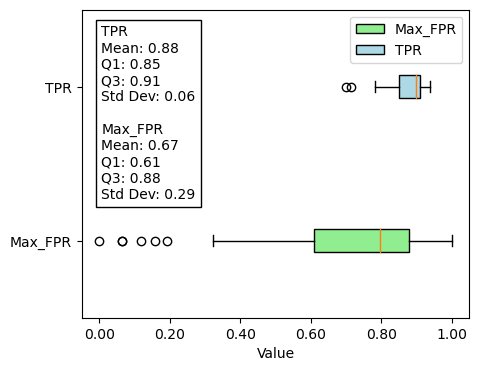

In [87]:
# Generate sample data

series1 = list(TPR.values())
series2 = list(max_FPR.values())

# Calculate statistics
series1_stats = {
    'mean': np.mean(series1),
    'q1': np.percentile(series1, 25),
    'q3': np.percentile(series1, 75),
    'std': np.std(series1)
}

series2_stats = {
    'mean': np.mean(series2),
    'q1': np.percentile(series2, 25),
    'q3': np.percentile(series2, 75),
    'std': np.std(series2)
}

# Create a figure and axis
fig, ax = plt.subplots(figsize=(5, 4))

# Plot the box plots
box_plot = ax.boxplot([series2, series1], patch_artist=True, vert=False)

# Customize the box colors
colors = ['lightgreen', 'lightblue']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

# Add a red diamond for the means
#means = [series1_stats['mean'], series2_stats['mean']]
#ax.plot(means, [1, 2], marker='D', color='red', markersize=8)

# Set the axis labels and title
ax.set_xticklabels(ax.get_xticks(), rotation=0)
ax.set_yticklabels(['Max_FPR', 'TPR'], rotation=0)
ax.set_xlabel('Value')
#ax.set_title('Box Chart with Statistics')

# Add a legend
legend_text = ['Max_FPR', 'TPR']
ax.legend(box_plot['boxes'] + [ax.lines[0]], legend_text)

# Add text annotations for statistics
stats_text = (
    f"TPR\nMean: {series1_stats['mean']:.2f}\nQ1: {series1_stats['q1']:.2f}"
    f"\nQ3: {series1_stats['q3']:.2f}\nStd Dev: {series1_stats['std']:.2f}\n\n"
    f"Max_FPR\nMean: {series2_stats['mean']:.2f}\nQ1: {series2_stats['q1']:.2f}"
    f"\nQ3: {series2_stats['q3']:.2f}\nStd Dev: {series2_stats['std']:.2f}"
)
ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10, va='top', bbox={'facecolor': 'white'})
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.2f}'))
# Display the plot
plt.show()

In [ ]:
#38 128-50-128 n:10 sw
#38 128-50-128 n:10 sw batch:16
#37 128-50-128 n:10 z:15 sw
#36 128-64-50-64-128 n:10
#36 128-50-128 n:10 batch:8
#35 128-30-128 n:5
#34 128-40-128 n:4
#34 128-30-128 n:3
#33 128-50-125 n:25
#33 128-30-128 z:15 n:3
#33 128-40-128 n:5
#31 64-30-64 n:3
#31 128-30-128 n:2
#31 64-20-64 z:10 n:2
#30 128-20-128 n:10
#29 128-20-128 z:15 n:5
#26 128-50-128 n:10
#28 128-30-128 n:10
#23 64-30-64 n:10
#22 128-40-128 z:inf n:5
#21 32-30-32 n:10

In [23]:
from tensorflow.keras import mixed_precision

# Enable mixed precision training
#mixed_precision.set_global_policy('mixed_float16')

In [24]:
# Scaled dot product attention
def scaled_dot_product_attention(q, k, v):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32) #float32 
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)

    return output, attention_weights

In [25]:
# Multi-head attention
class MultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)

        self.dense = layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, _ = scaled_dot_product_attention(q, k, v)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        output = self.dense(concat_attention)
        return output

In [26]:
# Transformer encoder layer
class EncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1, name=None, **kwargs):
        super(EncoderLayer, self).__init__(name=name, **kwargs)

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = models.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)])

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, x, training):
        attn_output = self.mha(x, x, x)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [27]:
# Transformer encoder
def create_encoder(input_shape, num_layers, d_model, num_heads, dff, rate=0.1):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    for _ in range(num_layers):
        x = EncoderLayer(d_model, num_heads, dff, rate)(x, training=True)

    encoder = models.Model(inputs=inputs, outputs=x)
    return encoder

In [28]:
# Transformer decoder layer
class DecoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1, name=None, **kwargs):
        super(DecoderLayer, self).__init__(name=name, **kwargs)

        self.self_mha = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = models.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)])
        
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.dropout3 = layers.Dropout(rate)

    def call(self, x, enc_output, training):
        attn_output1 = self.self_mha(x, x, x)
        attn_output1 = self.dropout1(attn_output1, training=training)
        out1 = self.layernorm1(x + attn_output1)

        attn_output2 = self.enc_dec_mha(out1, enc_output, enc_output)
        attn_output2 = self.dropout2(attn_output2, training=training)
        out2 = self.layernorm2(out1 + attn_output2)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(out2 + ffn_output)

        return out3


In [29]:
def create_decoder(input_shape, num_layers, d_model, num_heads, dff, rate=0.1):
    inputs = layers.Input(shape=input_shape)
    enc_outputs = layers.Input(shape=input_shape)
    
    x = inputs
    for _ in range(num_layers):
        x = DecoderLayer(d_model, num_heads, dff, rate)(x, enc_outputs, training=True)

    x = layers.Dense(input_shape[-1])(x)
    decoder = models.Model(inputs=[inputs, enc_outputs], outputs=x)
    return decoder

In [30]:
custom_objects = {
    'EncoderLayer': EncoderLayer,
    'DecoderLayer': DecoderLayer
}


In [31]:
input_shape = (100, 215)
num_layers = 1
d_model = 215
num_heads = 5
dff = 32

In [34]:
dff_values=[256,1024]
num_layer_values=[1]
epoch_values=[10,20,50]
batch_values=[128,192,256,512]

In [3]:
max_FPR={}
with open('max_FPR.pkl', 'rb') as fp:
    max_FPR=pickle.load(fp)

TPR={}
with open('TPR.pkl', 'rb') as fp:
    TPR=pickle.load(fp)

best_params={}
with open('best_params.pkl', 'rb') as fp:
    best_params=pickle.load(fp)


In [50]:


strategy = tf.distribute.MirroredStrategy()

print(f'Number of devices: {strategy.num_replicas_in_sync}')

with strategy.scope():
    for dff in dff_values:
        for num_layers in num_layer_values:
            for e in epoch_values:
                for b in batch_values:
                    temp_max_FPR={}
                    temp_TPR={}
                    with open("progress.txt","a") as p:
                        p.write(str(dff)+" "+str(num_layers)+" "+str(e)+" "+str(b)+"\n")
                    print(dff,num_layers,e,b)
                    for f in file_names:

                        #if f in unidentified_devices:
                        print(f)

                        encoder = create_encoder(input_shape, num_layers, d_model, num_heads, dff)
                        decoder = create_decoder(input_shape, num_layers, d_model, num_heads, dff)

                        inputs = layers.Input(shape=input_shape)
                        encoded = encoder(inputs)
                        decoded = decoder([encoded, encoded])
                        autoencoder = models.Model(inputs=inputs, outputs=decoded)

                        # Compile the model
                        autoencoder.compile(optimizer='adam', loss='mse')
                        es = EarlyStopping(monitor='loss', mode='min',patience=20)
                        mc = ModelCheckpoint('test_2_model_transf_'+f+'.h5', monitor='loss', mode='min', save_best_only=True)

                        autoencoder.fit(df_dict_train[f], df_dict_train[f], epochs=e, batch_size=b, callbacks=[es, mc],verbose=0)#,validation_split=0.1)
                        model=autoencoder

                        model = load_model('test_2_model_transf_'+f+'.h5',custom_objects=custom_objects)
                        #models[f]=model

                        temp_max_FPR[f]=0

                        thresh = get_threshold_mse_percentage(model,df_dict_train[f],0.1)

                        print(thresh)    

                        mad_outliers = detect_outliers(model, df_dict_test_df[f][f], thresh)
                        unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
                        print(unique_elements,"    ",counts_elements/mad_outliers[0].shape[0],"    ",counts_elements)

                        if len(counts_elements)==2:
                            temp_TPR[f]=counts_elements[1]/mad_outliers[0].shape[0]
                        else:
                            temp_TPR[f]=0

                        for f2 in file_names:
                            if f != f2 and f.startswith(f2[:10]):
                                mad_outliers = detect_outliers(model, df_dict_test_df[f][f2], thresh)
                                unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
                                print(f2+" "+str(counts_elements))

                                if len(counts_elements)==2 and (counts_elements[1]/mad_outliers[0].shape[0])>temp_max_FPR[f]:
                                    temp_max_FPR[f]=counts_elements[1]/mad_outliers[0].shape[0]

                        print(temp_max_FPR[f])
                        
                        if f in TPR.keys():
                            if (temp_TPR[f]-temp_max_FPR[f])>(TPR[f]-max_FPR[f]):
                                TPR[f]=temp_TPR[f]
                                max_FPR[f]=temp_max_FPR[f]
                                best_params[f]="dff: "+str(dff)+" num_layers: "+str(num_layers)+" e: "+str(e)+" b: "+str(b)                            
                        else:
                            TPR[f]=temp_TPR[f]
                            max_FPR[f]=temp_max_FPR[f]
                            best_params[f]="dff: "+str(dff)+" num_layers: "+str(num_layers)+" e: "+str(e)+" b: "+str(b)
                        
                        print(TPR[f],max_FPR[f],best_params[f],"\n")
                        with open('TPR.pkl', 'wb') as fp:
                            pickle.dump(TPR, fp)
                        with open('max_FPR.pkl', 'wb') as fp:
                            pickle.dump(max_FPR, fp)
                        with open('best_params.pkl', 'wb') as fp:
                            pickle.dump(best_params, fp)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
256 1 10 128
feat_gpu_80_1f_02_ef_e7_b2
INFO:tensorflow:batch_all_reduce: 44 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 44 all-reduces with algorithm = nccl, num_packs = 1
[0.005279474671492555]
[False  True]      [0.17813132 0.82186868]      [1937 8937]
feat_gpu_80_1f_02_f1_e3_b0 [10880]
feat_gpu_80_1f_02_f1_e3_b7 [10877]
feat_gpu_80_1f_02_f1_e3_c0 [10875]
feat_gpu_80_1f_02_f1_e3_c7 [10862]
feat_gpu_80_1f_02_f1_e3_db [10878]
feat_gpu_80_1f_02_f1_e3_dd [10833    39]
feat_gpu_80_1f_02_f1_e3_e0 [10874]
feat_gpu_80_1f_02_f1_e4_04 [10870     7]
feat_gpu_80_1f_02_f1_e4_0c [10755   120]
0.011034482758620689
0.8470663969100607 0.017195402298850575 dff: 128 num_layers: 1 e: 20 b: 512 

feat_gpu_80_1f_02_f1_e3_b0
INFO:tensorflow:batch_all_reduce: 44 all-reduces with algorithm = nccl, num_

feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [8471 1950]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0.18712215718261202
0.5887150945206794 0.13722291526724884 dff: 128 num_layers: 1 e: 10 b: 128 

feat_gpu_b8_27_eb_2d_18_19
[0.005540760980962968]
[False  True]      [0.62446043 0.37553957]      [6510 3915]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_50_d

feat_gpu_b8_27_eb_ea_38_52 [11784]
0.1369481765834933
0.6026813880126183 0.04587332053742802 dff: 32 num_layers: 1 e: 50 b: 256 

feat_gpu_b8_27_eb_8c_24_61
[0.0039648822195459]
[False  True]      [0.32904427 0.67095573]      [3887 7926]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53_a8 [8283 3530]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0.29882333022940827
0.6485228138491492 0.17743164310505374 dff: 128 num_layers: 1 e: 20 b: 192 


feat_gpu_dc_a6_32_14_a6_53 [4937 5313]
feat_gpu_dc_a6_32_14_a8_d8 [10248]
feat_gpu_dc_a6_32_4c_8e_0a [11119]
feat_gpu_dc_a6_32_4c_90_fb [10040]
feat_gpu_dc_a6_32_4c_98_93 [7705]
feat_gpu_dc_a6_32_4c_99_bf [11113]
feat_gpu_dc_a6_32_4c_9a_79 [8543]
feat_gpu_dc_a6_32_e4_48_9e [10276]
feat_gpu_dc_a6_32_e4_48_b3 [10265]
0.5183414634146342
0.4075121951219512 0.3338536585365854 dff: 32 num_layers: 1 e: 20 b: 128 

feat_gpu_dc_a6_32_4c_8e_0a
[0.005236857721465042]
[False  True]      [0.23590251 0.76409749]      [2623 8496]
feat_gpu_dc_a6_32_14_a6_53 [10250]
feat_gpu_dc_a6_32_14_a8_d8 [10248]
feat_gpu_dc_a6_32_14_ab_0a [10250]
feat_gpu_dc_a6_32_4c_90_fb [10040]
feat_gpu_dc_a6_32_4c_98_93 [7705]
feat_gpu_dc_a6_32_4c_99_bf [11113]
feat_gpu_dc_a6_32_4c_9a_79 [8543]
feat_gpu_dc_a6_32_e4_48_9e [10276]
feat_gpu_dc_a6_32_e4_48_b3 [10265]
0
0.9318284018346974 0 dff: 32 num_layers: 1 e: 10 b: 512 

feat_gpu_dc_a6_32_4c_90_fb
[0.0060633883729889855]
[False  True]      [0.30049801 0.69950199]      [3017 7

[0.00779652890525917]
[False  True]      [0.43224858 0.56775142]      [4702 6176]
feat_gpu_80_1f_02_ef_e7_b2 [10874]
feat_gpu_80_1f_02_f1_e3_b0 [10880]
feat_gpu_80_1f_02_f1_e3_b7 [10877]
feat_gpu_80_1f_02_f1_e3_c0 [9785 1090]
feat_gpu_80_1f_02_f1_e3_c7 [9937  925]
feat_gpu_80_1f_02_f1_e3_dd [10872]
feat_gpu_80_1f_02_f1_e3_e0 [8959 1915]
feat_gpu_80_1f_02_f1_e4_04 [10877]
feat_gpu_80_1f_02_f1_e4_0c [10875]
0.17610814787566673
0.520775877918735 0.03632183908045977 dff: 32 num_layers: 1 e: 10 b: 128 

feat_gpu_80_1f_02_f1_e3_dd
[0.008171157625726823]
[False  True]      [0.3540287 0.6459713]      [3849 7023]
feat_gpu_80_1f_02_ef_e7_b2 [10656   218]
feat_gpu_80_1f_02_f1_e3_b0 [10880]
feat_gpu_80_1f_02_f1_e3_b7 [10877]
feat_gpu_80_1f_02_f1_e3_c0 [10875]
feat_gpu_80_1f_02_f1_e3_c7 [10791    71]
feat_gpu_80_1f_02_f1_e3_db [10878]
feat_gpu_80_1f_02_f1_e3_e0 [10670   204]
feat_gpu_80_1f_02_f1_e4_04 [10874     3]
feat_gpu_80_1f_02_f1_e4_0c [4929 5946]
0.5467586206896552
0.7031824871228844 0.41756

feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0.00028782500239854167
0.4760579598886863 0.0022072936660268716 dff: 32 num_layers: 1 e: 50 b: 128 

feat_gpu_b8_27_eb_4c_53_a8
[0.006528319435774112]
[False  True]      [0.3960044 0.6039956]      [4678 7135]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [9907 1906]
feat_gpu_b8_27_eb_8e_

[0.017454879532239096]
[False  True]      [0.42109898 0.57890102]      [2391 3287]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0
0.7606551602676999 0 dff: 32 num_layers: 1 e: 10 b: 512 

feat_gpu_b8_27_eb_dc_61_2f
[0.007589502126134051]
[False  True]      [0.36345926 0.63654074]      [4291 7515]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_

feat_gpu_dc_a6_32_14_a8_d8 [10248]
feat_gpu_dc_a6_32_14_ab_0a [10250]
feat_gpu_dc_a6_32_4c_8e_0a [11119]
feat_gpu_dc_a6_32_4c_90_fb [10040]
feat_gpu_dc_a6_32_4c_98_93 [7705]
feat_gpu_dc_a6_32_4c_99_bf [11113]
feat_gpu_dc_a6_32_4c_9a_79 [8543]
feat_gpu_dc_a6_32_e4_48_9e [10276]
0
0.7745737944471505 0.00575609756097561 dff: 128 num_layers: 1 e: 10 b: 512 

feat_gpu_e4_5f_01_53_3d_49
[0.008997127291212817]
[False  True]      [0.43460257 0.56539743]      [4828 6281]
feat_gpu_e4_5f_01_53_3d_85 [11109]
feat_gpu_e4_5f_01_53_3d_c5 [11109]
feat_gpu_e4_5f_01_53_3e_39 [11103]
feat_gpu_e4_5f_01_53_3f_03 [11100]
0
0.8876586551444775 0.037897200468088935 dff: 32 num_layers: 1 e: 10 b: 512 

feat_gpu_e4_5f_01_53_3d_85
[0.00852340179237132]
[False  True]      [0.3784319 0.6215681]      [4204 6905]
feat_gpu_e4_5f_01_53_3d_49 [11109]
feat_gpu_e4_5f_01_53_3d_c5 [11109]
feat_gpu_e4_5f_01_53_3e_39 [11103]
feat_gpu_e4_5f_01_53_3f_03 [11100]
0
0.7436312899450895 0 dff: 32 num_layers: 1 e: 10 b: 512 

feat_gp

[0.014102495281210532]
[False  True]      [0.49716863 0.50283137]      [5180 5239]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0
0.5848929839715904 0.014585932252183091 dff: 32 num_layers: 1 e: 10 b: 512 

feat_gpu_b8_27_eb_27_1f_a3
[0.013678193922202054]
[False  True]      [0.62479608 0.37520392]      [6511 3910]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [1041

feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0
0.8291712520104969 0 dff: 128 num_layers: 1 e: 10 b: 512 

feat_gpu_b8_27_eb_87_a7_ce
[0.023682770544192225]
[False  True]      [0.43343849 0.56656151]      [2748 3592]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [8403 2017]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e

[0.013494672823374812]
[False  True]      [0.15053659 0.84946341]      [1543 8707]
feat_gpu_dc_a6_32_14_a8_d8 [10248]
feat_gpu_dc_a6_32_14_ab_0a [8631 1619]
feat_gpu_dc_a6_32_4c_8e_0a [11119]
feat_gpu_dc_a6_32_4c_90_fb [10040]
feat_gpu_dc_a6_32_4c_98_93 [7705]
feat_gpu_dc_a6_32_4c_99_bf [11113]
feat_gpu_dc_a6_32_4c_9a_79 [8543]
feat_gpu_dc_a6_32_e4_48_9e [10276]
feat_gpu_dc_a6_32_e4_48_b3 [10265]
0.15795121951219512
0.8565853658536585 0.10478048780487804 dff: 256 num_layers: 1 e: 10 b: 192 

feat_gpu_dc_a6_32_14_a8_d8
[0.014088887533404568]
[False  True]      [0.78005464 0.21994536]      [7994 2254]
feat_gpu_dc_a6_32_14_a6_53 [9933  317]
feat_gpu_dc_a6_32_14_ab_0a [10249     1]
feat_gpu_dc_a6_32_4c_8e_0a [11119]
feat_gpu_dc_a6_32_4c_90_fb [10040]
feat_gpu_dc_a6_32_4c_98_93 [7705]
feat_gpu_dc_a6_32_4c_99_bf [11113]
feat_gpu_dc_a6_32_4c_9a_79 [8543]
feat_gpu_dc_a6_32_e4_48_9e [10276]
feat_gpu_dc_a6_32_e4_48_b3 [10265]
0.030926829268292683
0.7043325526932084 0.007804878048780488 dff: 32 n

feat_gpu_80_1f_02_f1_e4_04 [7815 3062]
feat_gpu_80_1f_02_f1_e4_0c [10832    43]
0.6922297919351869
0.5245012411510527 0.09988952310808323 dff: 32 num_layers: 1 e: 20 b: 128 

feat_gpu_80_1f_02_f1_e3_c0
[0.053346238063206784]
[False  True]      [0.07558621 0.92441379]      [  822 10053]
feat_gpu_80_1f_02_ef_e7_b2 [7885 2989]
feat_gpu_80_1f_02_f1_e3_b0 [5223 5657]
feat_gpu_80_1f_02_f1_e3_b7 [5723 5154]
feat_gpu_80_1f_02_f1_e3_c7 [5917 4945]
feat_gpu_80_1f_02_f1_e3_db [  855 10023]
feat_gpu_80_1f_02_f1_e3_dd [7754 3118]
feat_gpu_80_1f_02_f1_e3_e0 [5118 5756]
feat_gpu_80_1f_02_f1_e4_04 [8799 2078]
feat_gpu_80_1f_02_f1_e4_0c [7183 3692]
0.9214009928295642
0.7193563218390805 0.1355947784519213 dff: 32 num_layers: 1 e: 20 b: 256 

feat_gpu_80_1f_02_f1_e3_c7
[0.023398443468551963]
[False  True]      [0.09491806 0.90508194]      [1031 9831]
feat_gpu_80_1f_02_ef_e7_b2 [10684   190]
feat_gpu_80_1f_02_f1_e3_b0 [10880]
feat_gpu_80_1f_02_f1_e3_b7 [10418   459]
feat_gpu_80_1f_02_f1_e3_c0 [10847    28

[0.027674841363726096]
[False  True]      [0.44222649 0.55777351]      [4608 5812]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
[0.03018859391190245]
[False  True]      [0.77151905 0.22848095]      [8040 2381]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [10420     1]
feat_gpu_b8_27_eb_7f_ec_53 

feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0.6735438057767968
0.4216890595009597 0.06045485078207466 dff: 128 num_layers: 1 e: 20 b: 128 

feat_gpu_b8_27_eb_c2_b6_e9
[0.02554360928423905]
[False  True]      [0.32687426 0.67312574]      [3863 7955]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_50_d7_8b [10062  1755]
feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0.1485148514851485
0.6

[0.03418505296476158]
[False  True]      [0.23984549 0.76015451]      [2049 6494]
feat_gpu_dc_a6_32_14_a6_53 [10250]
feat_gpu_dc_a6_32_14_a8_d8 [10248]
feat_gpu_dc_a6_32_14_ab_0a [10250]
feat_gpu_dc_a6_32_4c_8e_0a [11119]
feat_gpu_dc_a6_32_4c_90_fb [10040]
feat_gpu_dc_a6_32_4c_98_93 [7705]
feat_gpu_dc_a6_32_4c_99_bf [7994 3119]
feat_gpu_dc_a6_32_e4_48_9e [10276]
feat_gpu_dc_a6_32_e4_48_b3 [10265]
0.28066228741114013
0.6100901322720356 0.023126068568343382 dff: 128 num_layers: 1 e: 20 b: 192 

feat_gpu_dc_a6_32_e4_48_9e
[0.02928063716611805]
[False  True]      [0.28405995 0.71594005]      [2919 7357]
feat_gpu_dc_a6_32_14_a6_53 [10076   174]
feat_gpu_dc_a6_32_14_a8_d8 [10248]
feat_gpu_dc_a6_32_14_ab_0a [9693  557]
feat_gpu_dc_a6_32_4c_8e_0a [11119]
feat_gpu_dc_a6_32_4c_90_fb [10040]
feat_gpu_dc_a6_32_4c_98_93 [7705]
feat_gpu_dc_a6_32_4c_99_bf [11113]
feat_gpu_dc_a6_32_4c_9a_79 [8543]
feat_gpu_dc_a6_32_e4_48_b3 [9295  970]
0.0944958597174866
0.7750097314130011 0 dff: 128 num_layers: 1 e: 

feat_gpu_80_1f_02_f1_e3_b7 [10877]
feat_gpu_80_1f_02_f1_e3_c0 [10875]
feat_gpu_80_1f_02_f1_e3_c7 [8915 1947]
feat_gpu_80_1f_02_f1_e3_db [10877     1]
feat_gpu_80_1f_02_f1_e3_dd [8353 2519]
feat_gpu_80_1f_02_f1_e3_e0 [9791 1083]
feat_gpu_80_1f_02_f1_e4_04 [10845    32]
0.23169610007358352
0.7653333333333333 0.23491537895511405 dff: 128 num_layers: 1 e: 10 b: 128 

feat_gpu_b8_27_eb_0e_9d_fb
[0.0025765075625107593]
[False  True]      [0.45622996 0.54377004]      [3841 4578]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]

feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0
0.6905287400441417 0.001919201612129354 dff: 32 num_layers: 1 e: 10 b: 512 

feat_gpu_b8_27_eb_7f_ec_53
[0.0017120707895072727]
[False  True]      [0.16710404 0.83289596]      [1974 9839]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_

feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0
0.8621010750867688 0.0009502316189571207 dff: 32 num_layers: 1 e: 10 b: 512 

feat_gpu_b8_27_eb_ea_38_52
[0.0011957407077413135]
[False  True]      [0.31763408 0.68236592]      [3743 8041]
feat_gpu_b8_27_eb_0e_9d_fb [8189  230]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53_a8 [10882   931]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11296   517]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [10833   980]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d

feat_gpu_80_1f_02_f1_e3_dd [10836    36]
feat_gpu_80_1f_02_f1_e3_e0 [10874]
feat_gpu_80_1f_02_f1_e4_04 [10850    27]
feat_gpu_80_1f_02_f1_e4_0c [10705   170]
0.015632183908045976
0.9217399301085157 0.048726670957065364 dff: 256 num_layers: 1 e: 10 b: 512 

feat_gpu_80_1f_02_f1_e3_b0
[0.003454634201841724]
[False  True]      [0.75487132 0.24512868]      [8213 2667]
feat_gpu_80_1f_02_ef_e7_b2 [10874]
feat_gpu_80_1f_02_f1_e3_b7 [10871     6]
feat_gpu_80_1f_02_f1_e3_c0 [5682 5193]
feat_gpu_80_1f_02_f1_e3_c7 [10846    16]
feat_gpu_80_1f_02_f1_e3_db [8103 2775]
feat_gpu_80_1f_02_f1_e3_dd [10872]
feat_gpu_80_1f_02_f1_e3_e0 [9286 1588]
feat_gpu_80_1f_02_f1_e4_04 [10877]
feat_gpu_80_1f_02_f1_e4_0c [10875]
0.47751724137931034
0.5602941176470588 0.03890012874747103 dff: 128 num_layers: 1 e: 10 b: 512 

feat_gpu_80_1f_02_f1_e3_b7
[0.00302580443619331]
[False  True]      [0.48230211 0.51769789]      [5246 5631]
feat_gpu_80_1f_02_ef_e7_b2 [10874]
feat_gpu_80_1f_02_f1_e3_b0 [10880]
feat_gpu_80_1f_02_

feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0
0.576978417266187 0 dff: 128 num_layers: 1 e: 10 b: 512 

feat_gpu_b8_27_eb_2d_d7_6b
[0.003959279349923881]
[False  True]      [0.75784323 0.24215677]      [7899 2524]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [8842 1579]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [9938  482]
feat_gpu_b8_27_eb_c2_

feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [5500  840]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0.13249211356466878
0.5897312859884837 0.014195583596214511 dff: 32 num_layers: 1 e: 50 b: 256 

feat_gpu_b8_27_eb_91_48_fe
[0.003796328697064634]
[False  True]      [0.51497121 0.48502879]      [5366 5054]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_1

feat_gpu_dc_a6_32_4c_8e_0a [11119]
feat_gpu_dc_a6_32_4c_98_93 [7705]
feat_gpu_dc_a6_32_4c_99_bf [11113]
feat_gpu_dc_a6_32_4c_9a_79 [8543]
feat_gpu_dc_a6_32_e4_48_9e [10276]
feat_gpu_dc_a6_32_e4_48_b3 [10265]
0
0.8720119521912351 0 dff: 32 num_layers: 1 e: 10 b: 512 

feat_gpu_dc_a6_32_4c_98_93
[0.006031232814346441]
[False  True]      [0.5174562 0.4825438]      [3987 3718]
feat_gpu_dc_a6_32_14_a6_53 [10250]
feat_gpu_dc_a6_32_14_a8_d8 [10248]
feat_gpu_dc_a6_32_14_ab_0a [10250]
feat_gpu_dc_a6_32_4c_8e_0a [11119]
feat_gpu_dc_a6_32_4c_90_fb [10040]
feat_gpu_dc_a6_32_4c_99_bf [11113]
feat_gpu_dc_a6_32_4c_9a_79 [8498   45]
feat_gpu_dc_a6_32_e4_48_9e [10276]
feat_gpu_dc_a6_32_e4_48_b3 [10265]
0.005267470443638066
0.8353017521090201 0.002608148214767515 dff: 32 num_layers: 1 e: 10 b: 512 

feat_gpu_dc_a6_32_4c_99_bf
[0.00380303739898564]
[False  True]      [0.70206065 0.29793935]      [7802 3311]
feat_gpu_dc_a6_32_14_a6_53 [10250]
feat_gpu_dc_a6_32_14_a8_d8 [10248]
feat_gpu_dc_a6_32_14_ab_0a [

[0.004701897345069188]
[False  True]      [0.3975538 0.6024462]      [4323 6551]
feat_gpu_80_1f_02_ef_e7_b2 [10874]
feat_gpu_80_1f_02_f1_e3_b0 [10880]
feat_gpu_80_1f_02_f1_e3_b7 [10877]
feat_gpu_80_1f_02_f1_e3_c0 [10721   154]
feat_gpu_80_1f_02_f1_e3_c7 [10469   393]
feat_gpu_80_1f_02_f1_e3_db [9681 1197]
feat_gpu_80_1f_02_f1_e3_dd [10771   101]
feat_gpu_80_1f_02_f1_e4_04 [10877]
feat_gpu_80_1f_02_f1_e4_0c [10606   269]
0.11003861003861004
0.5955490160014714 0.01894775570272259 dff: 128 num_layers: 1 e: 20 b: 192 

feat_gpu_80_1f_02_f1_e4_04
[0.004597569827178676]
[False  True]      [0.22285557 0.77714443]      [2424 8453]
feat_gpu_80_1f_02_ef_e7_b2 [10874]
feat_gpu_80_1f_02_f1_e3_b0 [10880]
feat_gpu_80_1f_02_f1_e3_b7 [10877]
feat_gpu_80_1f_02_f1_e3_c0 [10875]
feat_gpu_80_1f_02_f1_e3_c7 [10862]
feat_gpu_80_1f_02_f1_e3_db [10878]
feat_gpu_80_1f_02_f1_e3_dd [10872]
feat_gpu_80_1f_02_f1_e3_e0 [10874]
feat_gpu_80_1f_02_f1_e4_0c [10875]
0
0.9187275903282155 0.045337502299061985 dff: 256 num

feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0.30373317531533056
0.603995598069923 0.16134766782358417 dff: 256 num_layers: 1 e: 10 b: 192 

feat_gpu_b8_27_eb_50_d7_8b
[0.004127859765034587]
[False  True]      [0.42032665 0.57967335]      [4967 6850]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11403   415]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_3

feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11782     2]
0.00016972165648336727
0.7636794850076233 0.010353021045485404 dff: 256 num_layers: 1 e: 10 b: 512 

feat_gpu_b8_27_eb_e1_66_63
[0.004017294635816494]
[False  True]      [0.35850334 0.64149666]      [4235 7578]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_e

[0.004944951763515088]
[False  True]      [0.49851472 0.50148528]      [5538 5571]
feat_gpu_e4_5f_01_53_3d_49 [11109]
feat_gpu_e4_5f_01_53_3d_85 [11109]
feat_gpu_e4_5f_01_53_3e_39 [11103]
feat_gpu_e4_5f_01_53_3f_03 [11100]
0
0.8495814204698893 0 dff: 32 num_layers: 1 e: 10 b: 512 

feat_gpu_e4_5f_01_53_3e_39
[0.005040621321267824]
[False  True]      [0.41790507 0.58209493]      [4640 6463]
feat_gpu_e4_5f_01_53_3d_49 [11109]
feat_gpu_e4_5f_01_53_3d_85 [11109]
feat_gpu_e4_5f_01_53_3d_c5 [11109]
feat_gpu_e4_5f_01_53_3f_03 [11100]
0
0.8353598126632442 0 dff: 128 num_layers: 1 e: 50 b: 256 

feat_gpu_e4_5f_01_53_3f_03
[0.004702005515839018]
[False  True]      [0.32873874 0.67126126]      [3649 7451]
feat_gpu_e4_5f_01_53_3d_49 [11109]
feat_gpu_e4_5f_01_53_3d_85 [11109]
feat_gpu_e4_5f_01_53_3d_c5 [11109]
feat_gpu_e4_5f_01_53_3e_39 [11103]
0
0.7804504504504505 0.004140786749482402 dff: 32 num_layers: 1 e: 10 b: 512 

256 1 20 512
feat_gpu_80_1f_02_ef_e7_b2
[0.012421197338632804]
[False  True] 

feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [6648 3773]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6311   29]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0.36205738412820265
0.5887150945206794 0.13722291526724884 dff: 128 num_layers: 1 e: 10 b: 128 

feat_gpu_b8_27_eb_2d_18_19
[0.012704431925808071]
[False  True]      [0.51827338 0.48172662]      [5403 5022]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb

feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0.13896353166986564
0.6026813880126183 0.04587332053742802 dff: 32 num_layers: 1 e: 50 b: 256 

feat_gpu_b8_27_eb_8c_24_61
[0.010305853781647641]
[False  True]      [0.27478202 0.72521798]      [3246 8567]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53_a8 [8459 3354]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_

[0.013642988676566579]
[False  True]      [0.72526829 0.27473171]      [7434 2816]
feat_gpu_dc_a6_32_14_a6_53 [6124 4126]
feat_gpu_dc_a6_32_14_a8_d8 [10248]
feat_gpu_dc_a6_32_4c_8e_0a [11119]
feat_gpu_dc_a6_32_4c_90_fb [10040]
feat_gpu_dc_a6_32_4c_98_93 [7705]
feat_gpu_dc_a6_32_4c_99_bf [11113]
feat_gpu_dc_a6_32_4c_9a_79 [8543]
feat_gpu_dc_a6_32_e4_48_9e [10276]
feat_gpu_dc_a6_32_e4_48_b3 [10265]
0.4025365853658537
0.4075121951219512 0.3338536585365854 dff: 32 num_layers: 1 e: 20 b: 128 

feat_gpu_dc_a6_32_4c_8e_0a
[0.012858003502913789]
[False  True]      [0.18481878 0.81518122]      [2055 9064]
feat_gpu_dc_a6_32_14_a6_53 [10250]
feat_gpu_dc_a6_32_14_a8_d8 [10248]
feat_gpu_dc_a6_32_14_ab_0a [10250]
feat_gpu_dc_a6_32_4c_90_fb [10040]
feat_gpu_dc_a6_32_4c_98_93 [7705]
feat_gpu_dc_a6_32_4c_99_bf [11113]
feat_gpu_dc_a6_32_4c_9a_79 [8543]
feat_gpu_dc_a6_32_e4_48_9e [10276]
feat_gpu_dc_a6_32_e4_48_b3 [10265]
0
0.9318284018346974 0 dff: 32 num_layers: 1 e: 10 b: 512 

feat_gpu_dc_a6_32_4c_90

feat_gpu_80_1f_02_f1_e3_e0 [10161   713]
feat_gpu_80_1f_02_f1_e4_04 [10221   656]
feat_gpu_80_1f_02_f1_e4_0c [10743   132]
0.06556924774691926
0.8539863745166636 0.06619472280959823 dff: 32 num_layers: 1 e: 10 b: 256 

feat_gpu_80_1f_02_f1_e3_db
[0.0006473676391039694]
[False  True]      [0.56287921 0.43712079]      [6123 4755]
feat_gpu_80_1f_02_ef_e7_b2 [10874]
feat_gpu_80_1f_02_f1_e3_b0 [10880]
feat_gpu_80_1f_02_f1_e3_b7 [10877]
feat_gpu_80_1f_02_f1_e3_c0 [9722 1153]
feat_gpu_80_1f_02_f1_e3_c7 [10747   115]
feat_gpu_80_1f_02_f1_e3_dd [10872]
feat_gpu_80_1f_02_f1_e3_e0 [10576   298]
feat_gpu_80_1f_02_f1_e4_04 [10877]
feat_gpu_80_1f_02_f1_e4_0c [10875]
0.10602298850574712
0.5984555984555985 0.1018944270737539 dff: 256 num_layers: 1 e: 10 b: 256 

feat_gpu_80_1f_02_f1_e3_dd
[0.0005111667226963274]
[False  True]      [0.31576527 0.68423473]      [3433 7439]
feat_gpu_80_1f_02_ef_e7_b2 [9751 1123]
feat_gpu_80_1f_02_f1_e3_b0 [10880]
feat_gpu_80_1f_02_f1_e3_b7 [10782    95]
feat_gpu_80_1f_02

feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10400    23]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10350    70]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0.0067178502879078695
0.4760579598886863 0.0022072936660268716 dff: 32 num_layers: 1 e: 50 b: 128 

feat_gpu_b8_27_eb_4c_53_a8
[0.001027566840529195]
[False  True]      [0.64175061 0.35824939]      [7581 4232]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_

feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0.00016924769400016924
0.6612794042985277 0.003215706186003216 dff: 128 num_layers: 1 e: 10 b: 192 

feat_gpu_b8_27_eb_d5_e5_0b
[0.0015848291753547085]
[False  True]      [0.67418105 0.32581895]      [3828 1850]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_9

feat_gpu_dc_a6_32_4c_90_fb [10040]
feat_gpu_dc_a6_32_4c_98_93 [7705]
feat_gpu_dc_a6_32_4c_99_bf [11113]
feat_gpu_dc_a6_32_4c_9a_79 [8543]
feat_gpu_dc_a6_32_e4_48_b3 [10265]
0
0.7750097314130011 0 dff: 128 num_layers: 1 e: 20 b: 128 

feat_gpu_dc_a6_32_e4_48_b3
[0.0005794205973364942]
[False  True]      [0.3518753 0.6481247]      [3612 6653]
feat_gpu_dc_a6_32_14_a6_53 [10248     2]
feat_gpu_dc_a6_32_14_a8_d8 [10248]
feat_gpu_dc_a6_32_14_ab_0a [10250]
feat_gpu_dc_a6_32_4c_8e_0a [11119]
feat_gpu_dc_a6_32_4c_90_fb [10040]
feat_gpu_dc_a6_32_4c_98_93 [7705]
feat_gpu_dc_a6_32_4c_99_bf [11113]
feat_gpu_dc_a6_32_4c_9a_79 [8543]
feat_gpu_dc_a6_32_e4_48_9e [10276]
0.0001951219512195122
0.8046760837798344 0.034439024390243905 dff: 256 num_layers: 1 e: 10 b: 512 

feat_gpu_e4_5f_01_53_3d_49
[0.0006475566690416614]
[False  True]      [0.67440814 0.32559186]      [7492 3617]
feat_gpu_e4_5f_01_53_3d_85 [11109]
feat_gpu_e4_5f_01_53_3d_c5 [11109]
feat_gpu_e4_5f_01_53_3e_39 [11103]
feat_gpu_e4_5f_01_53_3

feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0
0.7763392326879677 0.02903580800812664 dff: 256 num_layers: 1 e: 10 b: 512 

feat_gpu_b8_27_eb_1d_3b_13
[0.001486129125269302]
[False  True]      [0.5250024 0.4749976]      [5470 4949]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10410    10]
feat_gpu_b8_27_eb_4c_33_1b [10418     3]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [11813]


[0.0005208353632404763]
[False  True]      [0.40413104 0.59586896]      [4774 7039]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0
0.8328959620756793 0 dff: 256 num_layers: 1 e: 20 b: 128 

feat_gpu_b8_27_eb_87_a7_ce
[0.0015736237997218791]
[False  True]      [0.67444795 0.32555205]      [4276 2064]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_2

feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [10613  1200]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
0.10158300177770253
0.9413611676849966 0.10158300177770253 dff: 256 num_layers: 1 e: 50 b: 192 

feat_gpu_dc_a6_32_14_a6_53
[0.0008663970257161982]
[False  True]      [0.36058537 0.63941463]      [3696 6554]
feat_gpu_dc_a6_32_14_a8_d8 [10248]
feat_gpu_dc_a6_32_14_ab_0a [9561  689]
feat_gpu_dc_a6_32_4c_8e_0a [11119]
feat_gpu_dc_a6_32_4c_90_fb [10040]
feat_gpu_dc_a6_32_4c_98_93 [7705]
feat_gpu_dc_a6_32_4c_99_bf [11113]
feat_gpu_dc_a6_32_4c_9a_79 [8543]
feat_gpu_dc_a6_32_e4_48_9e [10276]
feat_gpu_dc_a6_32_e4_48_b3 [10265]
0.06721951219512196
0.8565853658536585 0.10478048780487804 dff: 256 num_layers: 1 e: 10 b: 192 

feat_gpu_dc_a6_32_14_a8_d8
[0.0007338430902558241]
[False  True]      [0.80601093 0.19398907] 

[False  True]      [0.39873127 0.60126873]      [4337 6540]
feat_gpu_80_1f_02_ef_e7_b2 [10870     4]
feat_gpu_80_1f_02_f1_e3_b0 [10880]
feat_gpu_80_1f_02_f1_e3_c0 [10844    31]
feat_gpu_80_1f_02_f1_e3_c7 [8417 2445]
feat_gpu_80_1f_02_f1_e3_db [10874     4]
feat_gpu_80_1f_02_f1_e3_dd [10849    23]
feat_gpu_80_1f_02_f1_e3_e0 [10671   203]
feat_gpu_80_1f_02_f1_e4_04 [10403   474]
feat_gpu_80_1f_02_f1_e4_0c [10141   734]
0.22509666728042718
0.5245012411510527 0.09988952310808323 dff: 32 num_layers: 1 e: 20 b: 128 

feat_gpu_80_1f_02_f1_e3_c0
[0.0010785328791364226]
[False  True]      [0.16248276 0.83751724]      [1767 9108]
feat_gpu_80_1f_02_ef_e7_b2 [10874]
feat_gpu_80_1f_02_f1_e3_b0 [10880]
feat_gpu_80_1f_02_f1_e3_b7 [10848    29]
feat_gpu_80_1f_02_f1_e3_c7 [10148   714]
feat_gpu_80_1f_02_f1_e3_db [5457 5421]
feat_gpu_80_1f_02_f1_e3_dd [10872]
feat_gpu_80_1f_02_f1_e3_e0 [7082 3792]
feat_gpu_80_1f_02_f1_e4_04 [10877]
feat_gpu_80_1f_02_f1_e4_0c [10875]
0.4983452840595698
0.7193563218390805

feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10071   349]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0.0552730064293254
0.41091816175765133 0.04135879474138758 dff: 32 num_layers: 1 e: 50 b: 192 

feat_gpu_b8_27_eb_31_6d_f3
[0.0016134700484191492]
[False  True]      [0.53262956 0.46737044]      [5550 4870]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2

[0.0015305475955564019]
[False  True]      [0.67274472 0.32725528]      [7010 3410]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10322   101]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [8582 1839]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0.17647058823529413
0.4216890595009597 0.06045485078207466 dff: 128 num_layers: 1 e: 20 b: 128 

feat_gpu_b8_27_eb_c2_b6_e9
[0.001322874696295451]
[False  True]      [0.47097648 0.52902352]      [5566 6252]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
fea

[0.001206083275990885]
[False  True]      [0.6693962 0.3306038]      [7439 3674]
feat_gpu_dc_a6_32_14_a6_53 [10250]
feat_gpu_dc_a6_32_14_a8_d8 [10248]
feat_gpu_dc_a6_32_14_ab_0a [10250]
feat_gpu_dc_a6_32_4c_8e_0a [11119]
feat_gpu_dc_a6_32_4c_90_fb [10040]
feat_gpu_dc_a6_32_4c_98_93 [7705]
feat_gpu_dc_a6_32_4c_9a_79 [8524   19]
feat_gpu_dc_a6_32_e4_48_9e [10276]
feat_gpu_dc_a6_32_e4_48_b3 [10265]
0.002224043076202739
0.9669756141455953 0.059697998361231415 dff: 256 num_layers: 1 e: 20 b: 128 

feat_gpu_dc_a6_32_4c_9a_79
[0.002273467185702004]
[False  True]      [0.44995903 0.55004097]      [3844 4699]
feat_gpu_dc_a6_32_14_a6_53 [10250]
feat_gpu_dc_a6_32_14_a8_d8 [10248]
feat_gpu_dc_a6_32_14_ab_0a [10250]
feat_gpu_dc_a6_32_4c_8e_0a [11119]
feat_gpu_dc_a6_32_4c_90_fb [10040]
feat_gpu_dc_a6_32_4c_98_93 [7705]
feat_gpu_dc_a6_32_4c_99_bf [10987   126]
feat_gpu_dc_a6_32_e4_48_9e [10276]
feat_gpu_dc_a6_32_e4_48_b3 [10265]
0.011338072527670296
0.6940184946740021 0.0602897507423738 dff: 256 num_

feat_gpu_80_1f_02_f1_e3_c0 [10875]
feat_gpu_80_1f_02_f1_e3_c7 [10862]
feat_gpu_80_1f_02_f1_e3_db [10878]
feat_gpu_80_1f_02_f1_e3_dd [10872]
feat_gpu_80_1f_02_f1_e3_e0 [10874]
feat_gpu_80_1f_02_f1_e4_0c [10875]
0
0.9187275903282155 0.045337502299061985 dff: 256 num_layers: 1 e: 10 b: 512 

feat_gpu_80_1f_02_f1_e4_0c
[0.003418590157063549]
[False  True]      [0.28349425 0.71650575]      [3083 7792]
feat_gpu_80_1f_02_ef_e7_b2 [10491   383]
feat_gpu_80_1f_02_f1_e3_b0 [10880]
feat_gpu_80_1f_02_f1_e3_b7 [10877]
feat_gpu_80_1f_02_f1_e3_c0 [10875]
feat_gpu_80_1f_02_f1_e3_c7 [10810    52]
feat_gpu_80_1f_02_f1_e3_db [10878]
feat_gpu_80_1f_02_f1_e3_dd [6874 3998]
feat_gpu_80_1f_02_f1_e3_e0 [10814    60]
feat_gpu_80_1f_02_f1_e4_04 [10877]
0.36773362766740253
0.7653333333333333 0.23491537895511405 dff: 128 num_layers: 1 e: 10 b: 128 

feat_gpu_b8_27_eb_0e_9d_fb
[0.005043345979388771]
[False  True]      [0.40551134 0.59448866]      [3414 5005]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_

feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11146   672]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0.05686241326789643
0.7141406448337141 0.011338635979015061 dff: 128 num_layers: 1 e: 10 b: 512 

feat_gpu_b8_27_eb_6d_af_a9
[0.006308670619263277]
[False  True]      [0.62249304 0.37750696]      [6487 3934]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c

feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0
0.8621010750867688 0.0009502316189571207 dff: 32 num_layers: 1 e: 10 b: 512 

feat_gpu_b8_27_eb_ea_38_52
[0.002960940900338773]
[False  True]      [0.32807196 0.67192804]      [3866 7918]
feat_gpu_b8_27_eb_0e_9d_fb [7870  549]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat

[0.004744204444586923]
[False  True]      [0.20516829 0.79483171]      [2231 8643]
feat_gpu_80_1f_02_f1_e3_b0 [10880]
feat_gpu_80_1f_02_f1_e3_b7 [10877]
feat_gpu_80_1f_02_f1_e3_c0 [10875]
feat_gpu_80_1f_02_f1_e3_c7 [10862]
feat_gpu_80_1f_02_f1_e3_db [10878]
feat_gpu_80_1f_02_f1_e3_dd [10651   221]
feat_gpu_80_1f_02_f1_e3_e0 [10874]
feat_gpu_80_1f_02_f1_e4_04 [10876     1]
feat_gpu_80_1f_02_f1_e4_0c [10287   588]
0.05406896551724138
0.9217399301085157 0.048726670957065364 dff: 256 num_layers: 1 e: 10 b: 512 

feat_gpu_80_1f_02_f1_e3_b0
[0.004500269286893686]
[False  True]      [0.86755515 0.13244485]      [9439 1441]
feat_gpu_80_1f_02_ef_e7_b2 [10874]
feat_gpu_80_1f_02_f1_e3_b7 [10877]
feat_gpu_80_1f_02_f1_e3_c0 [10615   260]
feat_gpu_80_1f_02_f1_e3_c7 [10826    36]
feat_gpu_80_1f_02_f1_e3_db [10878]
feat_gpu_80_1f_02_f1_e3_dd [10872]
feat_gpu_80_1f_02_f1_e3_e0 [10228   646]
feat_gpu_80_1f_02_f1_e4_04 [10877]
feat_gpu_80_1f_02_f1_e4_0c [10869     6]
0.05940776163325363
0.560294117647058

feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0
0.6631175059952038 0 dff: 256 num_layers: 1 e: 20 b: 256 

feat_gpu_b8_27_eb_2d_d7_6b
[0.0063174825363766255]
[False  True]      [0.56931785 0.43068215]      [5934 4489]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [8717 1704]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_a

feat_gpu_b8_27_eb_ea_38_52 [11784]
0.16473376788284094
0.6142385507491747 0.09227122661474646 dff: 256 num_layers: 1 e: 50 b: 256 

feat_gpu_b8_27_eb_8e_97_06
[0.005882493906798975]
[False  True]      [0.45019194 0.54980806]      [4691 5729]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [5512  828]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0.1305993690851735
0.5897312859884837 0.014195583596214511 dff: 32 num_layers: 1 e: 50 b: 2

[0.006113903807058269]
[False  True]      [0.28276892 0.71723108]      [2839 7201]
feat_gpu_dc_a6_32_14_a6_53 [10250]
feat_gpu_dc_a6_32_14_a8_d8 [10248]
feat_gpu_dc_a6_32_14_ab_0a [10250]
feat_gpu_dc_a6_32_4c_8e_0a [11119]
feat_gpu_dc_a6_32_4c_98_93 [7705]
feat_gpu_dc_a6_32_4c_99_bf [11113]
feat_gpu_dc_a6_32_4c_9a_79 [8543]
feat_gpu_dc_a6_32_e4_48_9e [10276]
feat_gpu_dc_a6_32_e4_48_b3 [10265]
0
0.8720119521912351 0 dff: 32 num_layers: 1 e: 10 b: 512 

feat_gpu_dc_a6_32_4c_98_93
[0.007968435547094307]
[False  True]      [0.52900714 0.47099286]      [4076 3629]
feat_gpu_dc_a6_32_14_a6_53 [10250]
feat_gpu_dc_a6_32_14_a8_d8 [10248]
feat_gpu_dc_a6_32_14_ab_0a [10250]
feat_gpu_dc_a6_32_4c_8e_0a [11119]
feat_gpu_dc_a6_32_4c_90_fb [10040]
feat_gpu_dc_a6_32_4c_99_bf [11113]
feat_gpu_dc_a6_32_4c_9a_79 [8485   58]
feat_gpu_dc_a6_32_e4_48_9e [10276]
feat_gpu_dc_a6_32_e4_48_b3 [10265]
0.0067891841273557295
0.8353017521090201 0.002608148214767515 dff: 32 num_layers: 1 e: 10 b: 512 

feat_gpu_dc_a6_3

[0.006470408128867041]
[False  True]      [0.35810189 0.64189811]      [3894 6980]
feat_gpu_80_1f_02_ef_e7_b2 [10874]
feat_gpu_80_1f_02_f1_e3_b0 [10880]
feat_gpu_80_1f_02_f1_e3_b7 [10877]
feat_gpu_80_1f_02_f1_e3_c0 [10836    39]
feat_gpu_80_1f_02_f1_e3_c7 [10481   381]
feat_gpu_80_1f_02_f1_e3_db [9756 1122]
feat_gpu_80_1f_02_f1_e3_dd [10360   512]
feat_gpu_80_1f_02_f1_e4_04 [10877]
feat_gpu_80_1f_02_f1_e4_0c [10114   761]
0.10314396028681742
0.5955490160014714 0.01894775570272259 dff: 128 num_layers: 1 e: 20 b: 192 

feat_gpu_80_1f_02_f1_e4_04
[0.006845908646899374]
[False  True]      [0.23480739 0.76519261]      [2554 8323]
feat_gpu_80_1f_02_ef_e7_b2 [10874]
feat_gpu_80_1f_02_f1_e3_b0 [10880]
feat_gpu_80_1f_02_f1_e3_b7 [10877]
feat_gpu_80_1f_02_f1_e3_c0 [10875]
feat_gpu_80_1f_02_f1_e3_c7 [10862]
feat_gpu_80_1f_02_f1_e3_db [10878]
feat_gpu_80_1f_02_f1_e3_dd [10872]
feat_gpu_80_1f_02_f1_e3_e0 [10874]
feat_gpu_80_1f_02_f1_e4_0c [10875]
0
0.9187275903282155 0.045337502299061985 dff: 256 n

feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0.11919072208583764
0.603995598069923 0.16134766782358417 dff: 256 num_layers: 1 e: 10 b: 192 

feat_gpu_b8_27_eb_50_d7_8b
[0.007051836626050621]
[False  True]      [0.47820936 0.52179064]      [5651 6166]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11742    76]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_3

feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0
0.7636794850076233 0.010353021045485404 dff: 256 num_layers: 1 e: 10 b: 512 

feat_gpu_b8_27_eb_e1_66_63
[0.007210843621059462]
[False  True]      [0.40540083 0.59459917]      [4789 7024]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu

feat_gpu_e4_5f_01_53_3d_49 [11109]
feat_gpu_e4_5f_01_53_3d_85 [11109]
feat_gpu_e4_5f_01_53_3e_39 [11103]
feat_gpu_e4_5f_01_53_3f_03 [11100]
0
0.8495814204698893 0 dff: 32 num_layers: 1 e: 10 b: 512 

feat_gpu_e4_5f_01_53_3e_39
[0.007908064757213633]
[False  True]      [0.22489417 0.77510583]      [2497 8606]
feat_gpu_e4_5f_01_53_3d_49 [11109]
feat_gpu_e4_5f_01_53_3d_85 [11109]
feat_gpu_e4_5f_01_53_3d_c5 [11109]
feat_gpu_e4_5f_01_53_3f_03 [11100]
0
0.8353598126632442 0 dff: 128 num_layers: 1 e: 50 b: 256 

feat_gpu_e4_5f_01_53_3f_03
[0.007644285534514157]
[False  True]      [0.38423423 0.61576577]      [4265 6835]
feat_gpu_e4_5f_01_53_3d_49 [11109]
feat_gpu_e4_5f_01_53_3d_85 [11109]
feat_gpu_e4_5f_01_53_3d_c5 [11109]
feat_gpu_e4_5f_01_53_3e_39 [11103]
0
0.7804504504504505 0.004140786749482402 dff: 32 num_layers: 1 e: 10 b: 512 

1024 1 10 256
feat_gpu_80_1f_02_ef_e7_b2
[0.008495768437692392]
[False  True]      [0.2115137 0.7884863]      [2300 8574]
feat_gpu_80_1f_02_f1_e3_b0 [10880]
fea

feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [9273 1148]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0.11016217253622493
0.5887150945206794 0.13722291526724884 dff: 128 num_layers: 1 e: 10 b: 128 

feat_gpu_b8_27_eb_2d_18_19
[0.01035648257190092]
[False  True]      [0.59434053 0.40565947]      [6196 4229]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53

feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0.0972168905950096
0.6026813880126183 0.04587332053742802 dff: 32 num_layers: 1 e: 50 b: 256 

feat_gpu_b8_27_eb_8c_24_61
[0.008707963621834111]
[False  True]      [0.31050538 0.68949462]      [3668 8145]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53_a8 [8571 3242]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0.27444340980275966
0.6142385507491747 0.09227122661474646 

feat_gpu_dc_a6_32_14_a6_53 [4204 6046]
feat_gpu_dc_a6_32_14_a8_d8 [10248]
feat_gpu_dc_a6_32_4c_8e_0a [11119]
feat_gpu_dc_a6_32_4c_90_fb [10040]
feat_gpu_dc_a6_32_4c_98_93 [7705]
feat_gpu_dc_a6_32_4c_99_bf [11113]
feat_gpu_dc_a6_32_4c_9a_79 [8543]
feat_gpu_dc_a6_32_e4_48_9e [10276]
feat_gpu_dc_a6_32_e4_48_b3 [10265]
0.5898536585365853
0.4075121951219512 0.3338536585365854 dff: 32 num_layers: 1 e: 20 b: 128 

feat_gpu_dc_a6_32_4c_8e_0a
[0.01011429401352559]
[False  True]      [0.15819768 0.84180232]      [1759 9360]
feat_gpu_dc_a6_32_14_a6_53 [10250]
feat_gpu_dc_a6_32_14_a8_d8 [10248]
feat_gpu_dc_a6_32_14_ab_0a [10250]
feat_gpu_dc_a6_32_4c_90_fb [10040]
feat_gpu_dc_a6_32_4c_98_93 [7705]
feat_gpu_dc_a6_32_4c_99_bf [11113]
feat_gpu_dc_a6_32_4c_9a_79 [8543]
feat_gpu_dc_a6_32_e4_48_9e [10276]
feat_gpu_dc_a6_32_e4_48_b3 [10265]
0
0.9318284018346974 0 dff: 32 num_layers: 1 e: 10 b: 512 

feat_gpu_dc_a6_32_4c_90_fb
[0.012332734590082446]
[False  True]      [0.20199203 0.79800797]      [2028 801

[0.0151111069124731]
[False  True]      [0.32460011 0.67539989]      [3531 7347]
feat_gpu_80_1f_02_ef_e7_b2 [10874]
feat_gpu_80_1f_02_f1_e3_b0 [10880]
feat_gpu_80_1f_02_f1_e3_b7 [10877]
feat_gpu_80_1f_02_f1_e3_c0 [10029   846]
feat_gpu_80_1f_02_f1_e3_c7 [10628   234]
feat_gpu_80_1f_02_f1_e3_dd [10872]
feat_gpu_80_1f_02_f1_e3_e0 [9415 1459]
feat_gpu_80_1f_02_f1_e4_04 [10877]
feat_gpu_80_1f_02_f1_e4_0c [10875]
0.1341732573110171
0.6753998896856039 0.1341732573110171 dff: 1024 num_layers: 1 e: 10 b: 512 

feat_gpu_80_1f_02_f1_e3_dd
[0.015069388588654389]
[False  True]      [0.26646431 0.73353569]      [2897 7975]
feat_gpu_80_1f_02_ef_e7_b2 [10123   751]
feat_gpu_80_1f_02_f1_e3_b0 [10880]
feat_gpu_80_1f_02_f1_e3_b7 [10877]
feat_gpu_80_1f_02_f1_e3_c0 [10875]
feat_gpu_80_1f_02_f1_e3_c7 [10733   129]
feat_gpu_80_1f_02_f1_e3_db [10878]
feat_gpu_80_1f_02_f1_e3_e0 [10783    91]
feat_gpu_80_1f_02_f1_e4_04 [10858    19]
feat_gpu_80_1f_02_f1_e4_0c [5007 5868]
0.5395862068965517
0.8083149374540103 0

feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10408    12]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0.0011516314779270633
0.4760579598886863 0.0022072936660268716 dff: 32 num_layers: 1 e: 50 b: 128 

feat_gpu_b8_27_eb_4c_53_a8
[0.01585974902516325]
[False  True]      [0.35240836 0.64759164]      [4163 7650]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8

[0.03206339155549972]
[False  True]      [0.3224727 0.6775273]      [1831 3847]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0
0.7606551602676999 0 dff: 32 num_layers: 1 e: 10 b: 512 

feat_gpu_b8_27_eb_dc_61_2f
[0.016175723824824455]
[False  True]      [0.25969846 0.74030154]      [3066 8740]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_

feat_gpu_dc_a6_32_14_a8_d8 [10248]
feat_gpu_dc_a6_32_14_ab_0a [10250]
feat_gpu_dc_a6_32_4c_8e_0a [11119]
feat_gpu_dc_a6_32_4c_90_fb [10040]
feat_gpu_dc_a6_32_4c_98_93 [7705]
feat_gpu_dc_a6_32_4c_99_bf [11113]
feat_gpu_dc_a6_32_4c_9a_79 [8543]
feat_gpu_dc_a6_32_e4_48_9e [10276]
0.006926829268292683
0.7951290793960059 0.006926829268292683 dff: 1024 num_layers: 1 e: 10 b: 512 

feat_gpu_e4_5f_01_53_3d_49
[0.018579747738507957]
[False  True]      [0.27446215 0.72553785]      [3049 8060]
feat_gpu_e4_5f_01_53_3d_85 [11109]
feat_gpu_e4_5f_01_53_3d_c5 [11109]
feat_gpu_e4_5f_01_53_3e_39 [11103]
feat_gpu_e4_5f_01_53_3f_03 [11100]
0
0.9094427941308849 0 dff: 256 num_layers: 1 e: 50 b: 512 

feat_gpu_e4_5f_01_53_3d_85
[0.018624794734669794]
[False  True]      [0.24295616 0.75704384]      [2699 8410]
feat_gpu_e4_5f_01_53_3d_49 [11109]
feat_gpu_e4_5f_01_53_3d_c5 [11109]
feat_gpu_e4_5f_01_53_3e_39 [11103]
feat_gpu_e4_5f_01_53_3f_03 [11100]
0
0.7570438383292826 0 dff: 1024 num_layers: 1 e: 10 b: 512 


[0.0016816402276860656]
[False  True]      [0.76581246 0.23418754]      [7979 2440]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0
0.5848929839715904 0.014585932252183091 dff: 32 num_layers: 1 e: 10 b: 512 

feat_gpu_b8_27_eb_27_1f_a3
[0.0023809111773719005]
[False  True]      [0.98675751 0.01324249]      [10283   138]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [

feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0
0.8328959620756793 0 dff: 256 num_layers: 1 e: 20 b: 128 

feat_gpu_b8_27_eb_87_a7_ce
[0.004844660353774138]
[False  True]      [0.75630915 0.24369085]      [4795 1545]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3 [10420]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [9179 1241]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e

feat_gpu_dc_a6_32_14_a8_d8 [10248]
feat_gpu_dc_a6_32_14_ab_0a [10087   163]
feat_gpu_dc_a6_32_4c_8e_0a [11119]
feat_gpu_dc_a6_32_4c_90_fb [10040]
feat_gpu_dc_a6_32_4c_98_93 [7705]
feat_gpu_dc_a6_32_4c_99_bf [11113]
feat_gpu_dc_a6_32_4c_9a_79 [8543]
feat_gpu_dc_a6_32_e4_48_9e [10276]
feat_gpu_dc_a6_32_e4_48_b3 [10265]
0.015902439024390244
0.8394146341463414 0.07482926829268292 dff: 1024 num_layers: 1 e: 10 b: 192 

feat_gpu_dc_a6_32_14_a8_d8
[0.001845877624750703]
[False  True]      [0.73614364 0.26385636]      [7544 2704]
feat_gpu_dc_a6_32_14_a6_53 [10250]
feat_gpu_dc_a6_32_14_ab_0a [10250]
feat_gpu_dc_a6_32_4c_8e_0a [11119]
feat_gpu_dc_a6_32_4c_90_fb [10040]
feat_gpu_dc_a6_32_4c_98_93 [7705]
feat_gpu_dc_a6_32_4c_99_bf [11113]
feat_gpu_dc_a6_32_4c_9a_79 [8543]
feat_gpu_dc_a6_32_e4_48_9e [10276]
feat_gpu_dc_a6_32_e4_48_b3 [10265]
0
0.7043325526932084 0.007804878048780488 dff: 32 num_layers: 1 e: 50 b: 128 

feat_gpu_dc_a6_32_14_ab_0a
[0.001618401086008316]
[False  True]      [0.7977561 

[0.0031896559755018013]
[False  True]      [0.19485057 0.80514943]      [2119 8756]
feat_gpu_80_1f_02_ef_e7_b2 [10874]
feat_gpu_80_1f_02_f1_e3_b0 [10880]
feat_gpu_80_1f_02_f1_e3_b7 [10850    27]
feat_gpu_80_1f_02_f1_e3_c7 [10218   644]
feat_gpu_80_1f_02_f1_e3_db [5280 5598]
feat_gpu_80_1f_02_f1_e3_dd [10872]
feat_gpu_80_1f_02_f1_e3_e0 [8682 2192]
feat_gpu_80_1f_02_f1_e4_04 [10877]
feat_gpu_80_1f_02_f1_e4_0c [10875]
0.5146166574738004
0.7193563218390805 0.1355947784519213 dff: 32 num_layers: 1 e: 20 b: 256 

feat_gpu_80_1f_02_f1_e3_c7
[0.0030988124293436104]
[False  True]      [0.23273799 0.76726201]      [2528 8334]
feat_gpu_80_1f_02_ef_e7_b2 [10874]
feat_gpu_80_1f_02_f1_e3_b0 [10880]
feat_gpu_80_1f_02_f1_e3_b7 [10692   185]
feat_gpu_80_1f_02_f1_e3_c0 [10860    15]
feat_gpu_80_1f_02_f1_e3_db [10849    29]
feat_gpu_80_1f_02_f1_e3_dd [10872]
feat_gpu_80_1f_02_f1_e3_e0 [10740   134]
feat_gpu_80_1f_02_f1_e4_04 [10716   161]
feat_gpu_80_1f_02_f1_e4_0c [10840    35]
0.017008366277466214
0.87

feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_4c_33_1b [10421]
feat_gpu_b8_27_eb_4c_53_a8 [11813]
feat_gpu_b8_27_eb_50_d7_8b [11817]
feat_gpu_b8_27_eb_6d_af_a9 [10421]
feat_gpu_b8_27_eb_7f_ec_53 [11813]
feat_gpu_b8_27_eb_87_a7_ce [6340]
feat_gpu_b8_27_eb_8c_24_61 [11813]
feat_gpu_b8_27_eb_8e_97_06 [10420]
feat_gpu_b8_27_eb_91_48_fe [10420]
feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0
0.5942418426103647 0 dff: 32 num_layers: 1 e: 10 b: 512 

feat_gpu_b8_27_eb_4c_33_1b
[0.004067367731714006]
[False  True]      [0.96574225 0.03425775]      [10064   357]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]
feat_gpu_b8_27_eb_2d_18_19 [10425]
feat_gpu_b8_27_eb_2d_d7_6b [10423]
feat_gpu_b8_27_eb_31_6d_f3

feat_gpu_b8_27_eb_c2_b6_e9 [11818]
feat_gpu_b8_27_eb_d5_e5_0b [5678]
feat_gpu_b8_27_eb_dc_61_2f [11806]
feat_gpu_b8_27_eb_e1_66_63 [11813]
feat_gpu_b8_27_eb_ea_38_52 [11784]
0.30073889262066983
0.641746641074856 0.15209672776125133 dff: 1024 num_layers: 1 e: 10 b: 512 

feat_gpu_b8_27_eb_c2_b6_e9
[0.0027024919655005575]
[False  True]      [0.65645625 0.34354375]      [7758 4060]
feat_gpu_b8_27_eb_0e_9d_fb [8419]
feat_gpu_b8_27_eb_1d_3b_13 [10419]
feat_gpu_b8_27_eb_27_1f_a3 [10421]



KeyboardInterrupt



In [4]:
#feat_gpu_dc_a6_32_14_ab_0a 0.4075121951219512

In [5]:
TPR["feat_gpu_dc_a6_32_14_ab_0a"]=0.6075121951219512

In [6]:
print(TPR)

{'feat_gpu_80_1f_02_ef_e7_b2': 0.9217399301085157, 'feat_gpu_80_1f_02_f1_e3_b0': 0.5602941176470588, 'feat_gpu_80_1f_02_f1_e3_b7': 0.5245012411510527, 'feat_gpu_80_1f_02_f1_e3_c0': 0.7193563218390805, 'feat_gpu_80_1f_02_f1_e3_c7': 0.8711102927637636, 'feat_gpu_80_1f_02_f1_e3_db': 0.6753998896856039, 'feat_gpu_80_1f_02_f1_e3_dd': 0.8083149374540103, 'feat_gpu_80_1f_02_f1_e3_e0': 0.5955490160014714, 'feat_gpu_80_1f_02_f1_e4_04': 0.9187275903282155, 'feat_gpu_80_1f_02_f1_e4_0c': 0.7653333333333333, 'feat_gpu_b8_27_eb_0e_9d_fb': 0.7763392326879677, 'feat_gpu_b8_27_eb_1d_3b_13': 0.5848929839715904, 'feat_gpu_b8_27_eb_27_1f_a3': 0.5887150945206794, 'feat_gpu_b8_27_eb_2d_18_19': 0.6631175059952038, 'feat_gpu_b8_27_eb_2d_d7_6b': 0.6287057469058812, 'feat_gpu_b8_27_eb_31_6d_f3': 0.5942418426103647, 'feat_gpu_b8_27_eb_4c_33_1b': 0.4760579598886863, 'feat_gpu_b8_27_eb_4c_53_a8': 0.6613053415728435, 'feat_gpu_b8_27_eb_50_d7_8b': 0.7141406448337141, 'feat_gpu_b8_27_eb_6d_af_a9': 0.6905287400441417,

In [7]:
print(max_FPR)

{'feat_gpu_80_1f_02_ef_e7_b2': 0.048726670957065364, 'feat_gpu_80_1f_02_f1_e3_b0': 0.03890012874747103, 'feat_gpu_80_1f_02_f1_e3_b7': 0.09988952310808323, 'feat_gpu_80_1f_02_f1_e3_c0': 0.1355947784519213, 'feat_gpu_80_1f_02_f1_e3_c7': 0.024551724137931035, 'feat_gpu_80_1f_02_f1_e3_db': 0.1341732573110171, 'feat_gpu_80_1f_02_f1_e3_dd': 0.4356781609195402, 'feat_gpu_80_1f_02_f1_e3_e0': 0.01894775570272259, 'feat_gpu_80_1f_02_f1_e4_04': 0.045337502299061985, 'feat_gpu_80_1f_02_f1_e4_0c': 0.23491537895511405, 'feat_gpu_b8_27_eb_0e_9d_fb': 0.02903580800812664, 'feat_gpu_b8_27_eb_1d_3b_13': 0.014585932252183091, 'feat_gpu_b8_27_eb_27_1f_a3': 0.13722291526724884, 'feat_gpu_b8_27_eb_2d_18_19': 0, 'feat_gpu_b8_27_eb_2d_d7_6b': 0.16381957773512476, 'feat_gpu_b8_27_eb_31_6d_f3': 0, 'feat_gpu_b8_27_eb_4c_33_1b': 0.0022072936660268716, 'feat_gpu_b8_27_eb_4c_53_a8': 0.20663675611614324, 'feat_gpu_b8_27_eb_50_d7_8b': 0.011338635979015061, 'feat_gpu_b8_27_eb_6d_af_a9': 0.001919201612129354, 'feat_gpu_

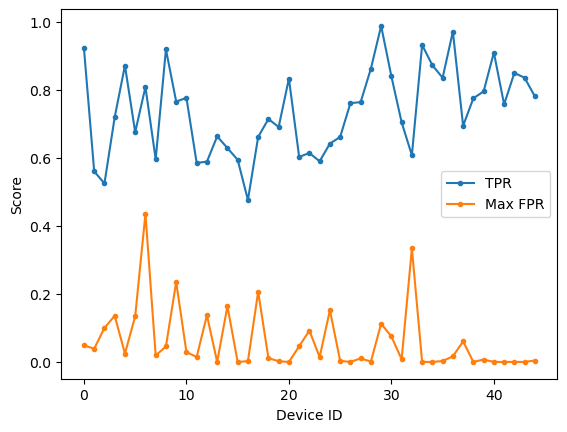

In [8]:
plt.plot(TPR.values(), label = "TPR",marker='.')
plt.plot(max_FPR.values(), label = "Max FPR",marker='.')
plt.legend()
plt.xlabel('Device ID')
plt.ylabel('Score') 
plt.savefig("Transformer.pdf", bbox_inches = "tight")
plt.show()

In [88]:
shared_items = {k: TPR[k] for k in TPR if k in max_FPR and TPR[k] > max_FPR[k]}
print(len(shared_items))

33


In [13]:
TPR.values()

dict_values([0.9217399301085157, 0.5602941176470588, 0.5245012411510527, 0.7193563218390805, 0.8711102927637636, 0.6753998896856039, 0.8083149374540103, 0.5955490160014714, 0.9187275903282155, 0.7653333333333333, 0.7763392326879677, 0.5848929839715904, 0.5887150945206794, 0.6631175059952038, 0.6287057469058812, 0.5942418426103647, 0.4760579598886863, 0.6613053415728435, 0.7141406448337141, 0.6905287400441417, 0.8328959620756793, 0.6026813880126183, 0.6142385507491747, 0.5897312859884837, 0.641746641074856, 0.6612794042985277, 0.7606551602676999, 0.7636794850076233, 0.8621010750867688, 0.9876951799049559, 0.8394146341463414, 0.7043325526932084, 0.6075121951219512, 0.9318284018346974, 0.8720119521912351, 0.8353017521090201, 0.9710249257626203, 0.6940184946740021, 0.7750097314130011, 0.7951290793960059, 0.9094427941308849, 0.7570438383292826, 0.8495814204698893, 0.8353598126632442, 0.7804504504504505])

/tmp/ipykernel_938666/2546608507.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=0)


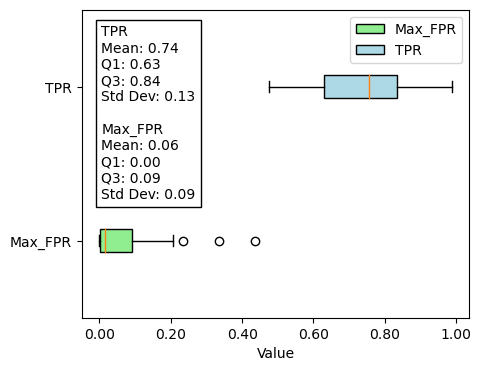

In [58]:
# Generate sample data

series1 = list(TPR.values())
series2 = list(max_FPR.values())

# Calculate statistics
series1_stats = {
    'mean': np.mean(series1),
    'q1': np.percentile(series1, 25),
    'q3': np.percentile(series1, 75),
    'std': np.std(series1)
}

series2_stats = {
    'mean': np.mean(series2),
    'q1': np.percentile(series2, 25),
    'q3': np.percentile(series2, 75),
    'std': np.std(series2)
}

# Create a figure and axis
fig, ax = plt.subplots(figsize=(5, 4))

# Plot the box plots
box_plot = ax.boxplot([series2, series1], patch_artist=True, vert=False)

# Customize the box colors
colors = ['lightgreen', 'lightblue']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

# Add a red diamond for the means
#means = [series1_stats['mean'], series2_stats['mean']]
#ax.plot(means, [1, 2], marker='D', color='red', markersize=8)

# Set the axis labels and title
ax.set_xticklabels(ax.get_xticks(), rotation=0)
ax.set_yticklabels(['Max_FPR', 'TPR'], rotation=0)
ax.set_xlabel('Value')
#ax.set_title('Box Chart with Statistics')

# Add a legend
legend_text = ['Max_FPR', 'TPR']
ax.legend(box_plot['boxes'] + [ax.lines[0]], legend_text)

# Add text annotations for statistics
stats_text = (
    f"TPR\nMean: {series1_stats['mean']:.2f}\nQ1: {series1_stats['q1']:.2f}"
    f"\nQ3: {series1_stats['q3']:.2f}\nStd Dev: {series1_stats['std']:.2f}\n\n"
    f"Max_FPR\nMean: {series2_stats['mean']:.2f}\nQ1: {series2_stats['q1']:.2f}"
    f"\nQ3: {series2_stats['q3']:.2f}\nStd Dev: {series2_stats['std']:.2f}"
)
ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10, va='top', bbox={'facecolor': 'white'})
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.2f}'))
plt.savefig("Box_plot.pdf", bbox_inches = "tight")
# Display the plot
plt.show()

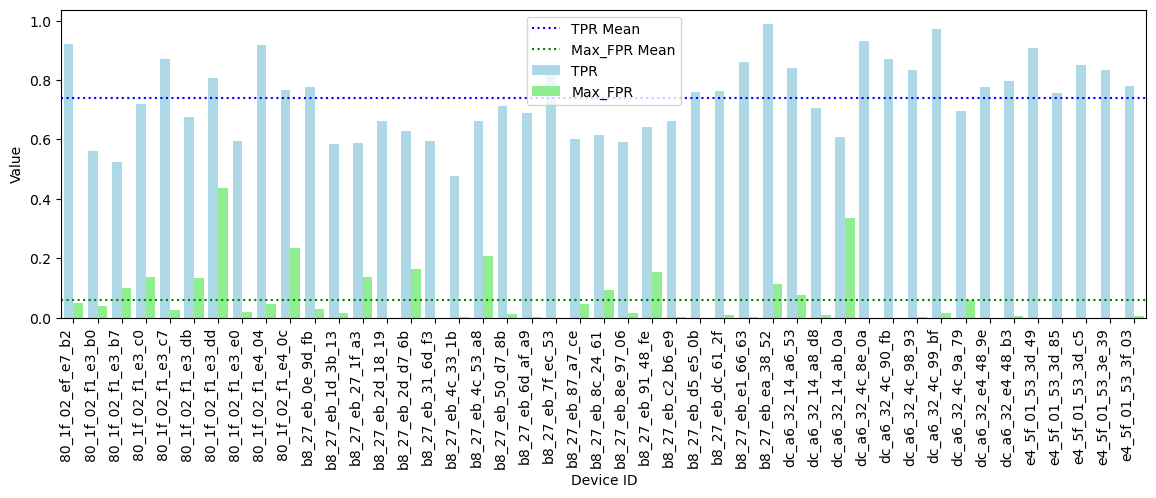

In [49]:
# Generate sample data

time_samples = np.arange(1, 46)
series1 = list(TPR.values())
series2 = list(max_FPR.values())


# Set the width of the bars
bar_width = 0.4

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 4))


# Get the colors from the previous box plot
colors = ['lightblue', 'lightgreen']

# Plot the bars with the same colors
ax.bar(time_samples - bar_width/2, series1, bar_width, label='TPR', color=colors[0])
ax.bar(time_samples + bar_width/2, series2, bar_width, label='Max_FPR', color=colors[1])

series1_avg = np.mean(series1)
series2_avg = np.mean(series2)

# Plot the averages as a dotted line
ax.axhline(series1_avg, color='blue', linestyle='dotted', label='TPR Mean')
ax.axhline(series2_avg, color='green', linestyle='dotted', label='Max_FPR Mean')

# Set custom labels for the X-axis
ax.set_xticks(time_samples)
labels = [string[9:] for string in list(TPR.keys())]
ax.set_xticklabels(labels, rotation=90, ha='right')


# Set the axis labels and title
ax.set_xlabel('Device ID')
ax.set_ylabel('Value')

# Adjust the x-axis limits for better visibility
ax.set_xlim(0.5, 45.5)

# Add a legend
ax.legend()
plt.savefig("Bar_plot.pdf", bbox_inches = "tight")

# Display the plot
plt.show()


In [69]:
#Input shape 20,215
#Transformer 39: 10 epochs dff 32 layers 2 batch 128
#Transformer 38: 10 epochs dff 32 layers 1 batch 128
#Transformer 38: 10 epochs dff 32 layers 1 batch 64
#Transformer 36: 20 epochs dff 32 layers 1 batch 32
#Transformer 34: 20 epochs dff 32 layers 1 batch 64


#Input shape 10,215
#Transformer 34: 10 epochs dff 32 layers 1 batch 128
#Transformer 33: 10 epochs dff 32 layers 2 batch 128


#Input shape 50,215
#Transformer 43: 10 epochs dff 64 layers 2 batch 128
#Transformer 42: 10 epochs dff 32 layers 1 batch 128
#Transformer 42: 10 epochs dff 64 layers 1 batch 128

#Input shape 100,215
#Transformer 45: 50 epochs dff 32 layers 1 batch 192. Better average TPR y FPR test_model_transf_
#Transformer 45: 10 epochs dff 32 layers 1 batch 128
#Transformer 45: 10 epochs dff 64 layers 2 batch 128
#Transformer 44: 20 epochs dff 512 layers 1 batch 512
#Transformer 44: 20 epochs dff 256 layers 1 batch 512
#Transformer 43: 20 epochs dff 2048 layers 1 batch 512


In [ ]:
def create_denoising_autoencoder(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.LSTM(128, return_sequences=True)(inputs)
    x = layers.LSTM(64, return_sequences=False)(x)
    encoded = layers.Dense(32, activation='relu')(x)

    # Decoder
    x = layers.RepeatVector(input_shape[0])(encoded)
    x = layers.LSTM(64, return_sequences=True)(x)
    x = layers.LSTM(128, return_sequences=True)(x)
    decoded = layers.TimeDistributed(layers.Dense(input_shape[1], activation='linear'))(x)

    autoencoder = models.Model(inputs=inputs, outputs=decoded)
    return autoencoder

autoencoder = create_denoising_autoencoder(input_shape)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()



history = autoencoder.fit(X_train_noisy, X_train, epochs=100, batch_size=32,
                          validation_data=(X_test_noisy, X_test))


In [ ]:
input_shape = (10, 215)

# Sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return mean + K.exp(0.5 * log_var) * epsilon

def create_variational_autoencoder(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.LSTM(128, return_sequences=True)(inputs)
    x = layers.LSTM(64, return_sequences=False)(x)
    x = layers.Dense(32)(x)

    z_mean = layers.Dense(16)(x)
    z_log_var = layers.Dense(16)(x)
    z = Sampling()([z_mean, z_log_var])

    # Decoder
    x = layers.Dense(64)(z)
    x = layers.RepeatVector(input_shape[0])(x)
    x = layers.LSTM(64, return_sequences=True)(x)
    x = layers.LSTM(128, return_sequences=True)(x)
    decoded = layers.TimeDistributed(layers.Dense(input_shape[1], activation='linear'))(x)

    vae = models.Model(inputs=inputs, outputs=decoded)

    # Define the VAE loss
    reconstruction_loss = losses.mean_squared_error(inputs, decoded)
    reconstruction_loss *= input_shape[0] * input_shape[1]
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    
    return vae

vae = create_variational_autoencoder(input_shape)
vae.compile(optimizer='adam')
vae.summary()

history = vae.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_test, X_test))




In [ ]:
def create_spatial_conv_autoencoder(input_shape=(10, 215, 1)):
    # Encoder
    encoder_input = layers.Input(shape=input_shape)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    decoder_input = layers.Input(shape=encoded.shape[1:])
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(decoder_input)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Autoencoder
    encoder = models.Model(encoder_input, encoded)
    decoder = models.Model(decoder_input, decoded)
    autoencoder = models.Model(encoder_input, decoder(encoded))

    return encoder, decoder, autoencoder

encoder, decoder, autoencoder = create_spatial_conv_autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')


In [ ]:
# Assuming X is your input data with a shape of (num_samples, 10, 215)
X_reshaped = X.reshape(-1, 10, 215, 1)

autoencoder.fit(X_reshaped, X_reshaped, epochs=100, batch_size=32, validation_split=0.1)